<a href="https://colab.research.google.com/github/artemkavara/Deep-Learning-KPI/blob/main/Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторна робота №5

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [ ]:
%notebook inline

In [ ]:
import zipfile

In [ ]:
import re
import os
import shutil

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras import layers

In [ ]:
from keras import backend

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
plt.style.use("seaborn-whitegrid")

In [ ]:
from sklearn.preprocessing import  MinMaxScaler

# Дані

In [ ]:
zip_source = "/content/archive.zip"
zip_ref = zipfile.ZipFile(zip_source, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
data = pd.read_csv("raw_sales.csv")
data["datesold"] = pd.to_datetime(data["datesold"])
data = data.set_index("datesold")
data

postcode   price propertyType  bedrooms
datesold                                           
2007-02-07      2607  525000        house         4
2007-02-27      2906  290000        house         3
2007-03-07      2905  328000        house         3
2007-03-09      2905  380000        house         4
2007-03-21      2906  310000        house         3
...              ...     ...          ...       ...
2019-07-25      2900  500000         unit         3
2019-07-25      2612  560000         unit         2
2019-07-26      2912  464950         unit         2
2019-07-26      2601  589000         unit         2
2019-07-26      2612  775000         unit         2

[29580 rows x 4 columns]

In [ ]:
len(np.unique(data.index))

3582

In [ ]:
len(data.index)

29580

In [ ]:
ts = data["price"].groupby(data.index).apply(lambda elem: np.mean(elem))

## Характеристики даних

In [ ]:
ts.describe()

count    3.582000e+03
mean     5.875967e+05
std      1.661998e+05
min      1.752530e+05
25%      5.005100e+05
50%      5.628424e+05
75%      6.414540e+05
max      5.475000e+06
Name: price, dtype: float64

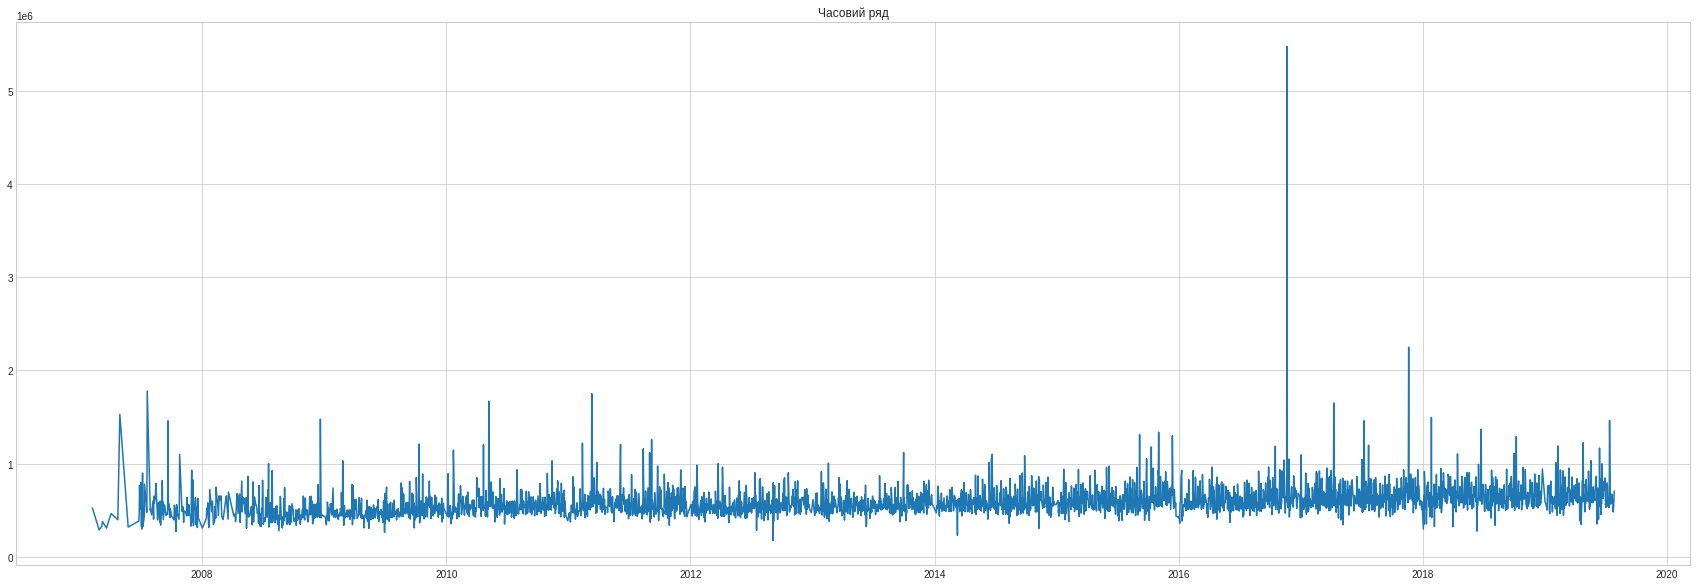

In [ ]:
fig, ax = plt.subplots(figsize = (30, 10))
ax.plot(ts)
ax.set_title("Часовий ряд");

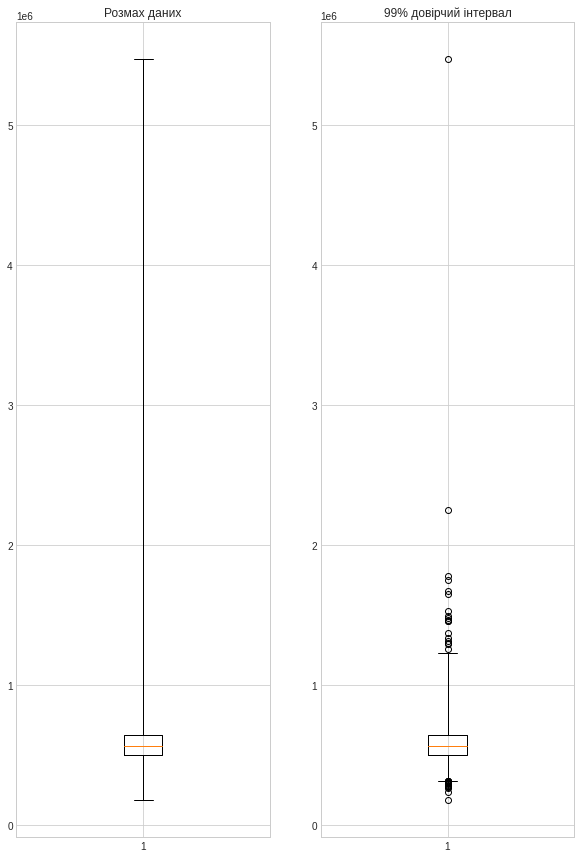

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 15))
ax[0].boxplot(ts, whis = (0, 100));
ax[0].set_title("Розмах даних")

ax[1].boxplot(ts, whis = (0.5, 99.5));
ax[1].set_title("99% довірчий інтервал");

## Очищення від викидів

In [ ]:
ts = ts[ts.between(ts.quantile(.005), ts.quantile(.995))]
ts 

datesold
2007-02-07    525000.000000
2007-03-07    328000.000000
2007-03-09    380000.000000
2007-04-04    465000.000000
2007-04-24    399000.000000
                  ...      
2019-07-23    562123.333333
2019-07-24    482500.000000
2019-07-25    547800.000000
2019-07-26    594408.333333
2019-07-27    707500.000000
Name: price, Length: 3546, dtype: float64

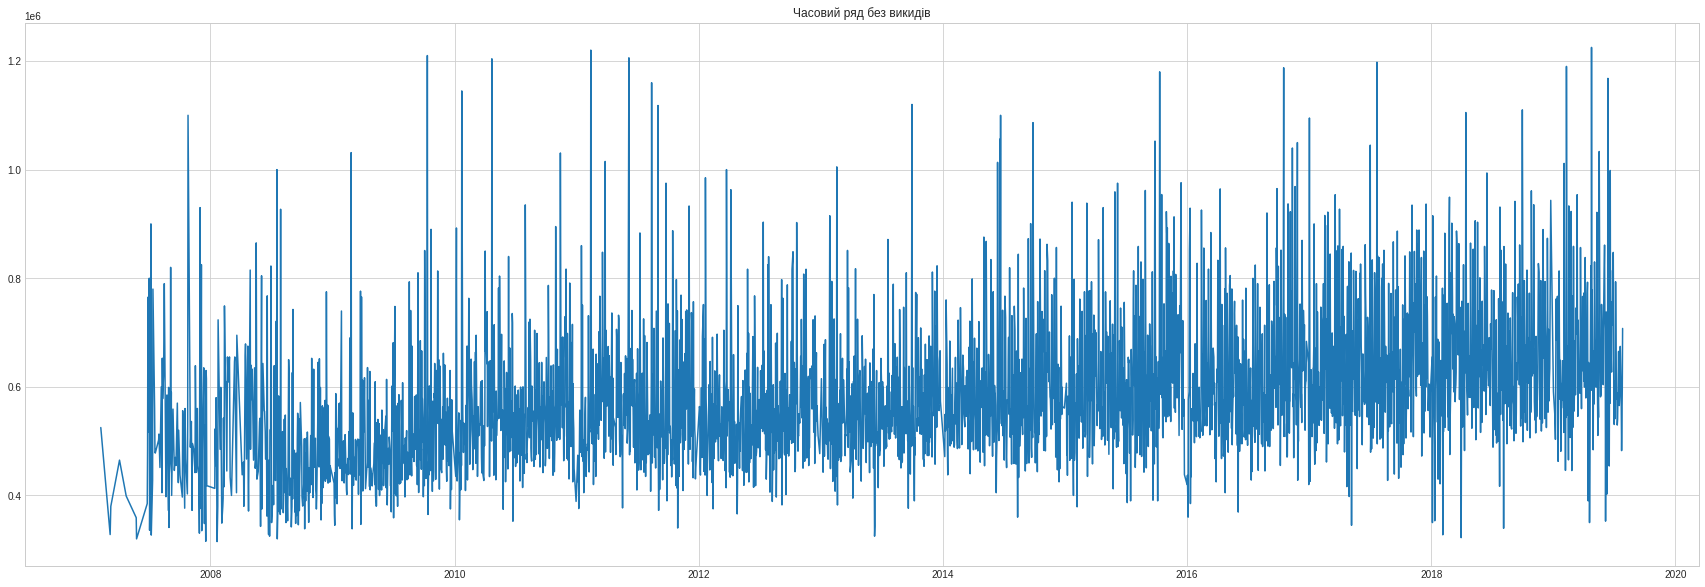

In [ ]:
fig, ax = plt.subplots(figsize = (30, 10))
ax.plot(ts)
ax.set_title("Часовий ряд без викидів");

# Поділ на тренувальну та тестувальну вибірки

In [ ]:
n = len(ts)
n

3546

In [ ]:
ts_train, ts_test = ts[1:int(n/4)].copy(), ts[int(n/4):].copy()

In [ ]:
len(ts_train)/len(ts_test)

0.33270676691729323

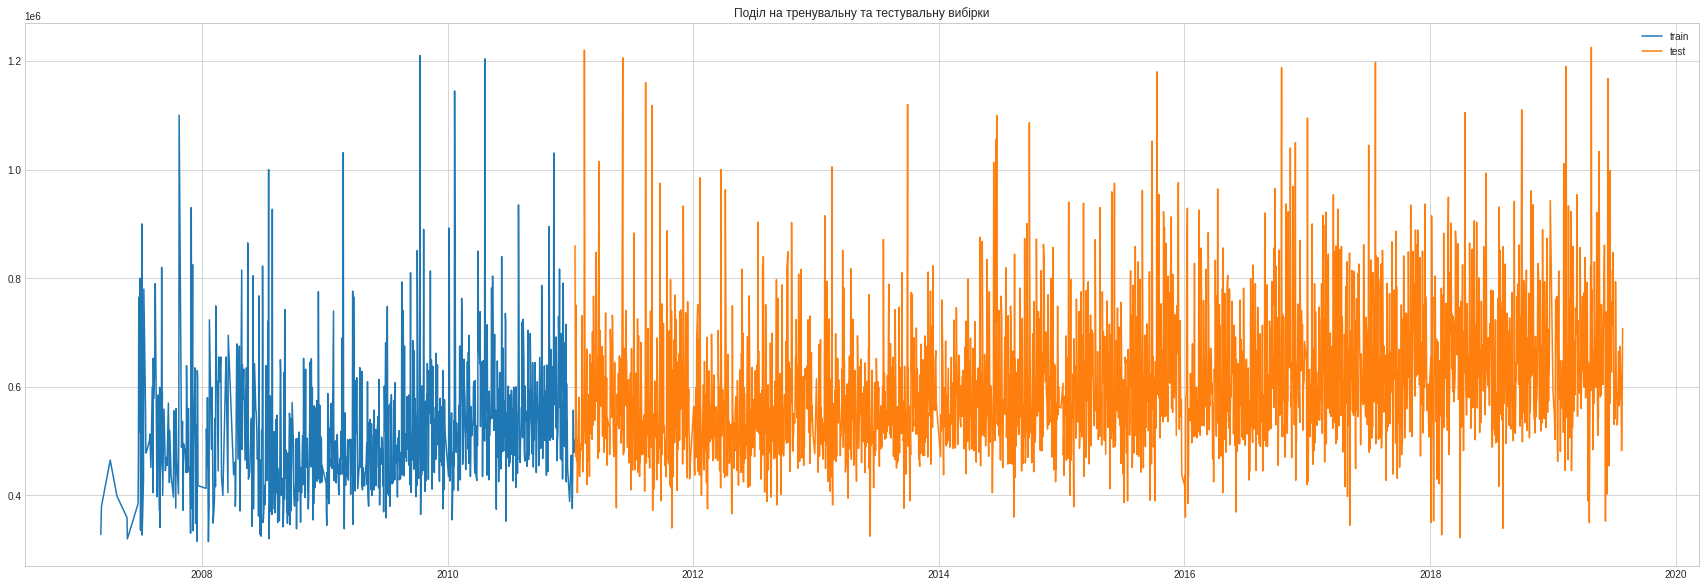

In [ ]:
fig, ax = plt.subplots(figsize = (30, 10))
ax.plot(ts_train, label = "train")
ax.plot(ts_test, label = "test")
ax.set_title("Поділ на тренувальну та тестувальну вибірки");
plt.legend();

In [ ]:
def norm_data(scaler, ts):
  ts = scaler.fit_transform(ts.to_numpy().reshape(-1,1))
  return ts

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
ts = norm_data(scaler, ts)

In [ ]:
ts_train, ts_test = ts[1:int(n/4)].copy(), ts[int(n/4):].copy()

# Допоміжні функції

In [ ]:
def create_ts_for_rnn(ts, window=1):
 tsX, tsY = [], []
 for i in range(len(ts)-window-1):
		a = ts[i:(i+window)]
		tsX.append(a)
		tsY.append(ts[i + window])
 tsX,tsY = np.array(tsX), np.array(tsY)
 tsX = np.reshape(tsX, (tsX.shape[0], 1, tsX.shape[1]))
 return tsX, tsY

In [ ]:
def calc_stats(pred_train, ts_train_y, pred_test, ts_test_y):
  rmse_train = np.sqrt(1/len(ts_train_y)*sum((ts_train_y.reshape(-1,) - pred_train.reshape(-1,))**2))
  print(f'RMSE on train: {rmse_train}')
  rmse_test = np.sqrt(1/len(ts_test_y)*sum((ts_test_y.reshape(-1,) - pred_test.reshape(-1,))**2))
  print(f'RMSE on test: {rmse_test}')
  mae_train = 1/len(ts_train_y)*sum(np.abs(ts_train_y.reshape(-1,) - pred_train.reshape(-1,)))
  print(f'MAE on train: {mae_train}')
  mae_test = 1/len(ts_test_y)*sum(np.abs(ts_test_y.reshape(-1,) - pred_test.reshape(-1,)))
  print(f'MAE on test: {mae_test}')
  mape_train = np.mean(np.abs((ts_train_y.reshape(-1,) - pred_train.reshape(-1,)) / ts_train_y.reshape(-1,))) * 100
  print(f'MAPE on train: {mape_train}')
  mape_test = np.mean(np.abs((ts_test_y.reshape(-1,) - pred_test.reshape(-1,)) / ts_test_y.reshape(-1,))) * 100
  print(f'MAPE on test: {mape_test}')

In [ ]:
def plot_results(pred_train, ts_train_y, pred_test, ts_test_y):
  fig, ax = plt.subplots(1, 2, figsize = (20, 10))
  ax[0].plot(ts_train_y, label = "Train data")
  ax[0].plot(pred_train, label = "Predict on train")
  ax[0].legend()
  ax[1].plot(ts_test_y, label = "Test data")
  ax[1].plot(pred_test, label = "Predict on test")
  ax[1].legend()

# Побудувати першу модель, використовуючи один шар базових рекурентних нейронiв, та аналогiчнi моделi iз одним шаром комiрок LSTM i GRU.

## Один шар базових рекурентних нейронів

In [ ]:
ts_train_X, ts_train_y = create_ts_for_rnn(ts_train)
ts_test_X, ts_test_y = create_ts_for_rnn(ts_test)

In [ ]:
model_1 = tf.keras.Sequential([
                               layers.SimpleRNN(1, input_shape = (None, 1)),
                               layers.Dense(1)
])
model_1.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_1 = model_1.fit(
      ts_train_X,
      ts_train_y,
      epochs = 20,
  )

Epoch 1/20
28/28 [==============================] - 1s 3ms/step - loss: 0.0592
Epoch 2/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0464
Epoch 3/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0360
Epoch 4/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0282
Epoch 5/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0196
Epoch 7/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 8/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 9/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 10/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 11/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 12/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 13/20
28/28 [==============================

In [ ]:
ts_train_y_unsc = scaler.inverse_transform(ts_train_y)
ts_test_y_unsc = scaler.inverse_transform(ts_test_y)

In [ ]:
pred_train = model_1.predict(ts_train_X)
pred_test = model_1.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 117850.75079808511
RMSE on test: 143673.16162713416
MAE on train: 85056.76687913961
MAE on test: 100797.46960802631
MAPE on train: 16.298025027890308
MAPE on test: 15.015346643557232


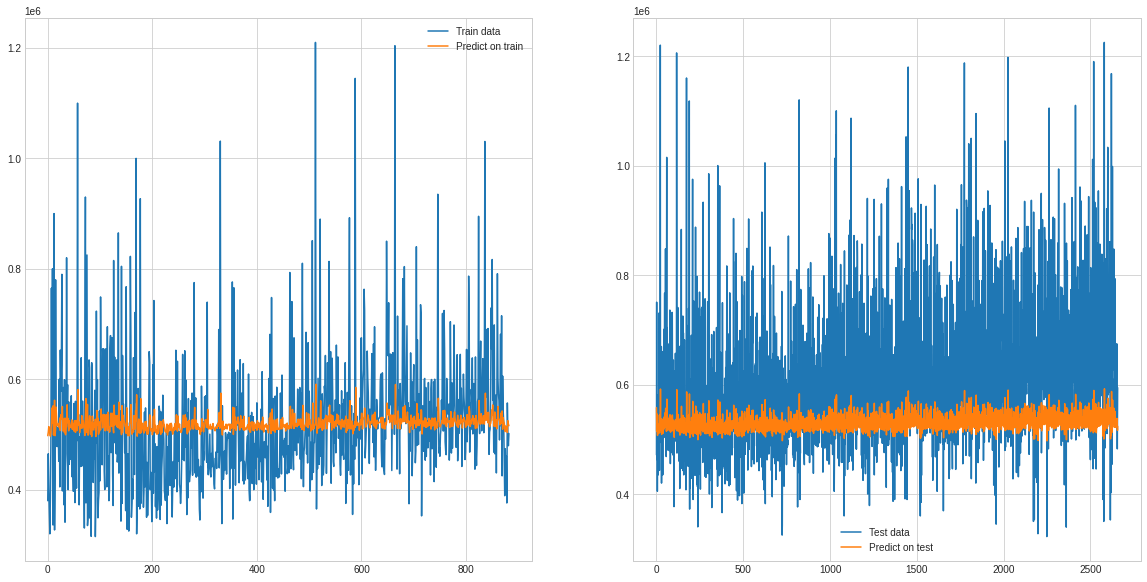

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

## Модель LSTM

In [ ]:
model_2 = tf.keras.Sequential([
                               layers.LSTM(1, input_shape = (None, 1)),
                               layers.Dense(1)
])
model_2.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_2 = model_2.fit(
      ts_train_X,
      ts_train_y,
      epochs = 20,
  )

Epoch 1/20
28/28 [==============================] - 5s 3ms/step - loss: 0.0638
Epoch 2/20
28/28 [==============================] - 0s 2ms/step - loss: 0.0525
Epoch 3/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0434
Epoch 4/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0363
Epoch 5/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0308
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0266
Epoch 7/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0235
Epoch 8/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0213
Epoch 9/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0197
Epoch 10/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 11/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 12/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 13/20
28/28 [==============================

In [ ]:
pred_train_2 = model_2.predict(ts_train_X)
pred_test_2 = model_2.predict(ts_test_X)
pred_train_2 = scaler.inverse_transform(pred_train_2)
pred_test_2 = scaler.inverse_transform(pred_test_2)

In [ ]:
calc_stats(pred_train_2, ts_train_y_unsc, pred_test_2, ts_test_y_unsc)

RMSE on train: 117871.67401349287
RMSE on test: 148934.529748233
MAE on train: 85590.40030904341
MAE on test: 105193.61075165417
MAPE on train: 16.43946903691549
MAPE on test: 15.56276586665116


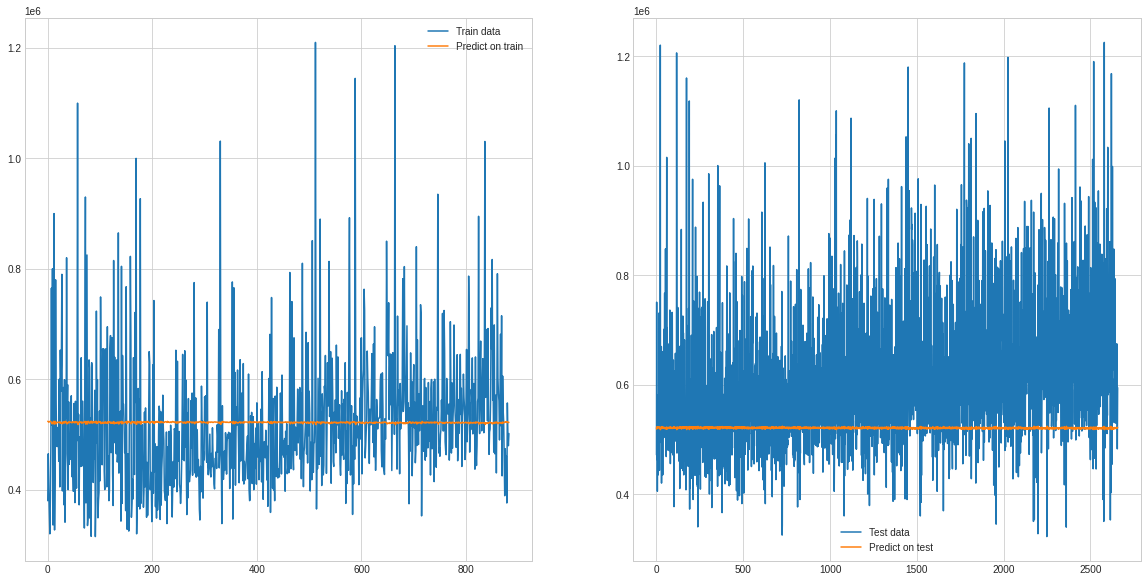

In [ ]:
plot_results(pred_train_2, ts_train_y_unsc, pred_test_2, ts_test_y_unsc)

## Модель GRU

In [ ]:
model_3 = tf.keras.Sequential([
                               layers.GRU(1, input_shape = (None, 1)),
                               layers.Dense(1)
])
model_3.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_3 = model_3.fit(
      ts_train_X,
      ts_train_y,
      epochs = 20,
  )

Epoch 1/20
28/28 [==============================] - 1s 3ms/step - loss: 0.0532
Epoch 2/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0377
Epoch 3/20
28/28 [==============================] - 0s 2ms/step - loss: 0.0269
Epoch 4/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 5/20
28/28 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0173
Epoch 7/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 8/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 9/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 10/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 11/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 12/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 13/20
28/28 [==============================

In [ ]:
pred_train_3 = model_3.predict(ts_train_X)
pred_test_3 = model_3.predict(ts_test_X)
pred_train_3 = scaler.inverse_transform(pred_train_3)
pred_test_3 = scaler.inverse_transform(pred_test_3)

In [ ]:
calc_stats(pred_train_3, ts_train_y_unsc, pred_test_3, ts_test_y_unsc)

RMSE on train: 118232.18280741895
RMSE on test: 143107.61867083804
MAE on train: 85255.61384930568
MAE on test: 100422.54747572441
MAPE on train: 16.316343921095797
MAPE on test: 14.993367894103194


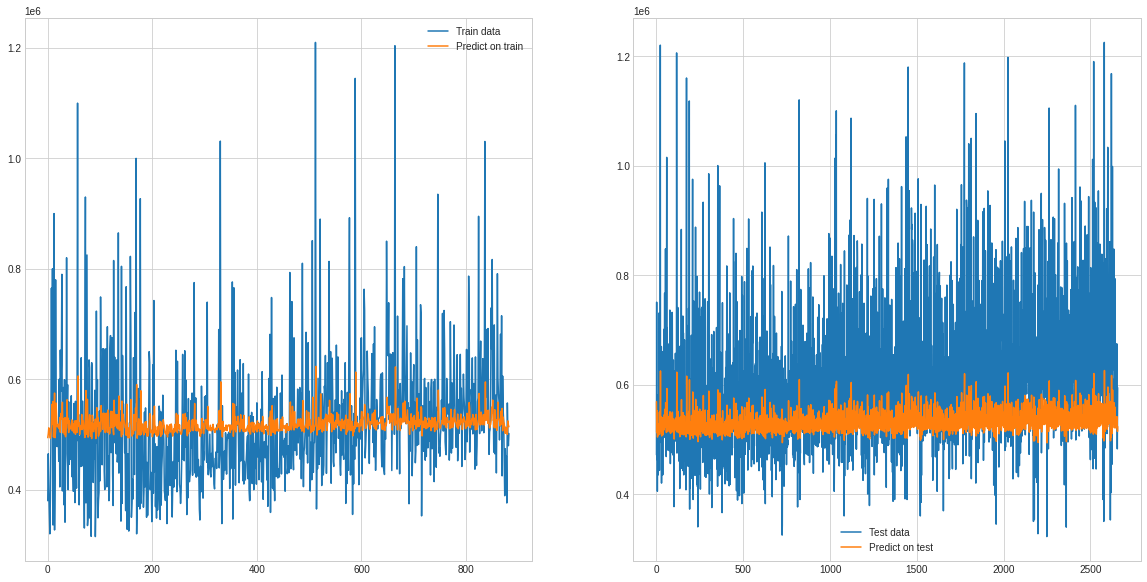

In [ ]:
plot_results(pred_train_3, ts_train_y_unsc, pred_test_3, ts_test_y_unsc)

# Спробувати пiдiбрати кiлькiсть нейронiв у рекурентному шарi, кiлькiсть часових крокiв, а також кiлькiсть епох i розмiр батчу, щоб покращити якiсть прогнозiв.

## Використання вікна розміру 7

### Simple RNN

In [ ]:
ts_train_X, ts_train_y = create_ts_for_rnn(ts_train, 7)
ts_test_X, ts_test_y = create_ts_for_rnn(ts_test, 7)

In [ ]:
model_4 = tf.keras.Sequential([
                               layers.SimpleRNN(1, input_shape = (None, 7)),
                               layers.Dense(1)
])
model_4.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_4 = model_4.fit(
      ts_train_X,
      ts_train_y,
      epochs = 20,
  )

Epoch 1/20
28/28 [==============================] - 1s 3ms/step - loss: 0.0523
Epoch 2/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0393
Epoch 3/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0358
Epoch 4/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0340
Epoch 5/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0325
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0311
Epoch 7/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0298
Epoch 8/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0287
Epoch 9/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0277
Epoch 10/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0267
Epoch 11/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 12/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0251
Epoch 13/20
28/28 [==============================

In [ ]:
ts_train_y_unsc = scaler.inverse_transform(ts_train_y)
ts_test_y_unsc = scaler.inverse_transform(ts_test_y)

In [ ]:
pred_train = model_4.predict(ts_train_X)
pred_test = model_4.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 131628.7220320714
RMSE on test: 143464.09300340837
MAE on train: 94966.5443494909
MAE on test: 104966.22744180015
MAPE on train: 18.15524204608234
MAPE on test: 16.46374625892726


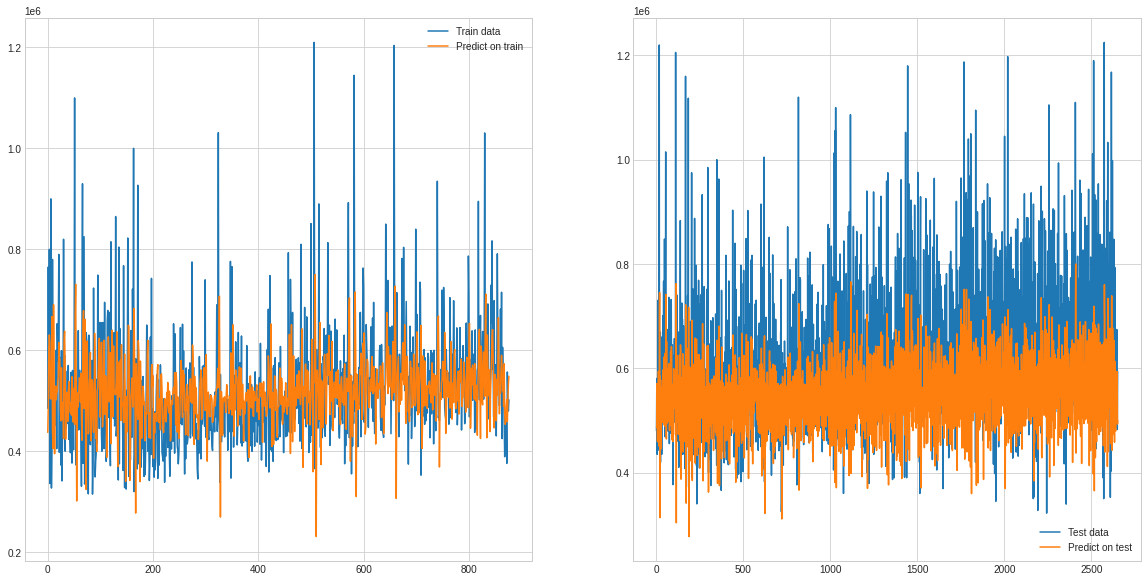

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

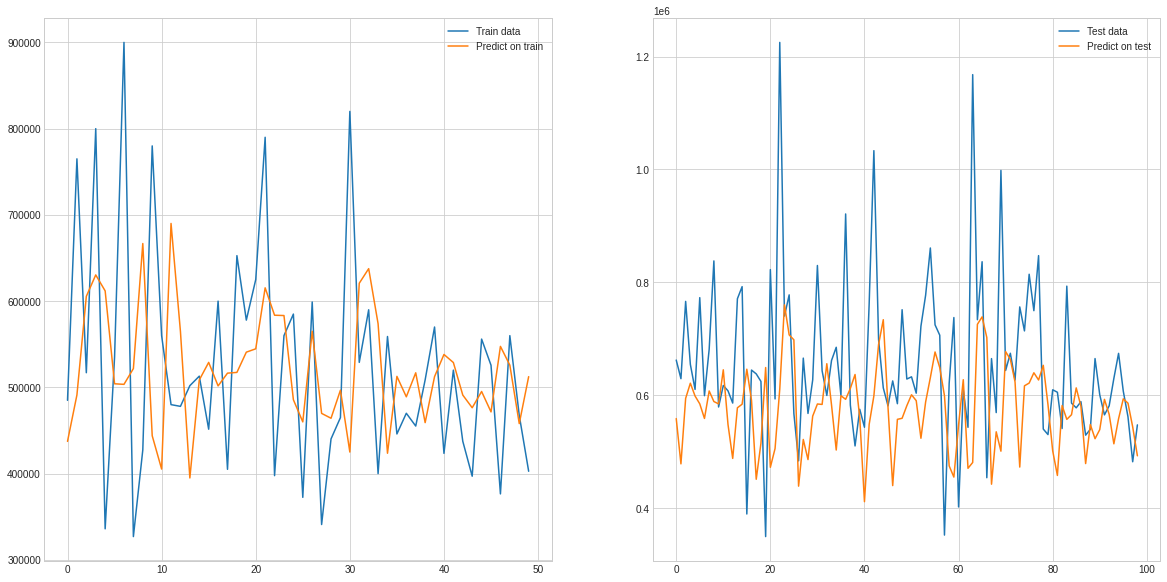

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

### LSTM зі збільшенням кількості units

In [ ]:
model_5 = tf.keras.Sequential([
                               layers.LSTM(32, input_shape = (None, 7)),
                               layers.Dense(1)
])
model_5.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_5 = model_5.fit(
      ts_train_X,
      ts_train_y,
      epochs = 20,
  )

Epoch 1/20
28/28 [==============================] - 1s 3ms/step - loss: 0.0449
Epoch 2/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 3/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 4/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 5/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 7/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 8/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 9/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 10/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 11/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 12/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 13/20
28/28 [==============================

In [ ]:
pred_train = model_5.predict(ts_train_X)
pred_test = model_5.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 116666.25404143246
RMSE on test: 131265.8145911584
MAE on train: 83964.82288670629
MAE on test: 90644.78509629343
MAPE on train: 16.07588075002441
MAPE on test: 13.753083696981664


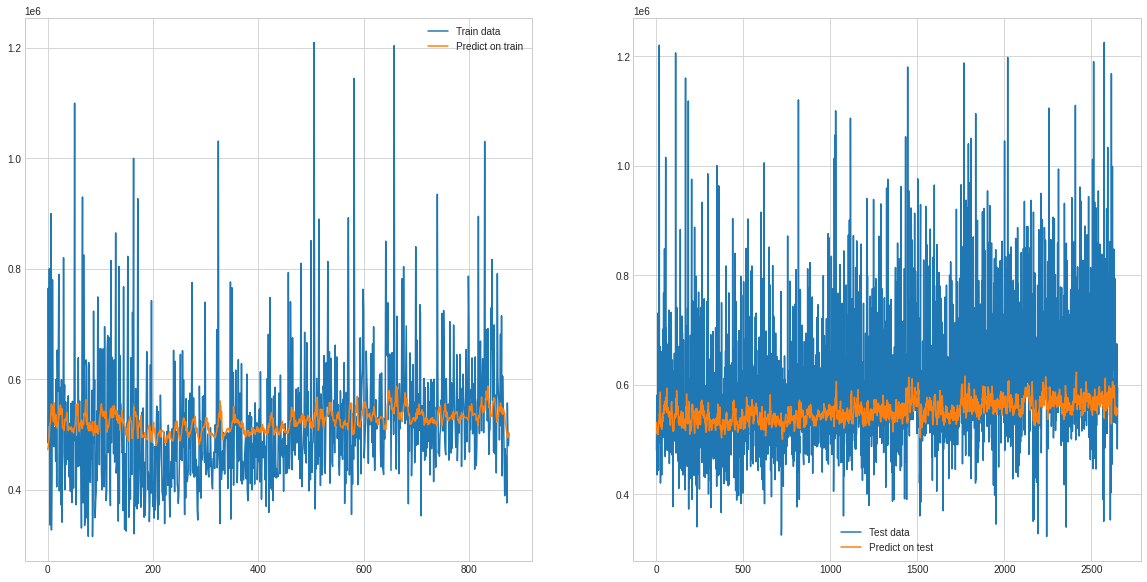

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

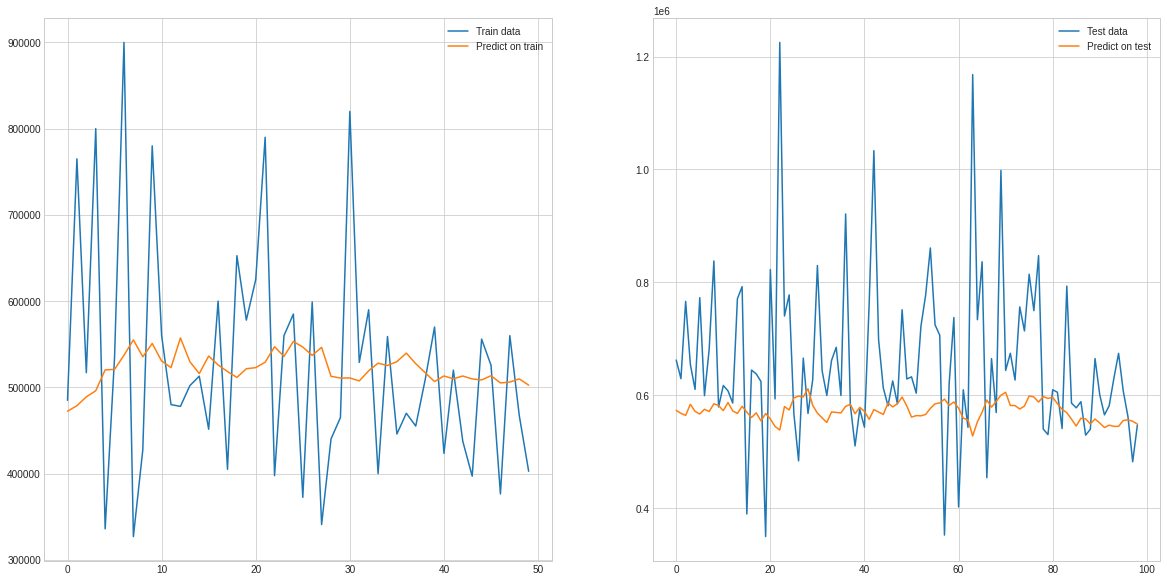

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

### Удосконалення моделей з використанням GRU

In [ ]:
model_6 = tf.keras.Sequential([
                               layers.GRU(128, input_shape = (None, 7)),
                               layers.Dense(1)
])
model_6.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_6 = model_6.fit(
      ts_train_X,
      ts_train_y,
      epochs = 20,
  )

Epoch 1/20
28/28 [==============================] - 1s 3ms/step - loss: 0.0228
Epoch 2/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 3/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 4/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 5/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 7/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 8/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 9/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 10/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 11/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 12/20
28/28 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 13/20
28/28 [==============================

In [ ]:
pred_train = model_6.predict(ts_train_X)
pred_test = model_6.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 116605.12016008727
RMSE on test: 136838.5381849883
MAE on train: 83785.19144508081
MAE on test: 94818.71096882083
MAPE on train: 15.958214409041746
MAPE on test: 14.200687041402446


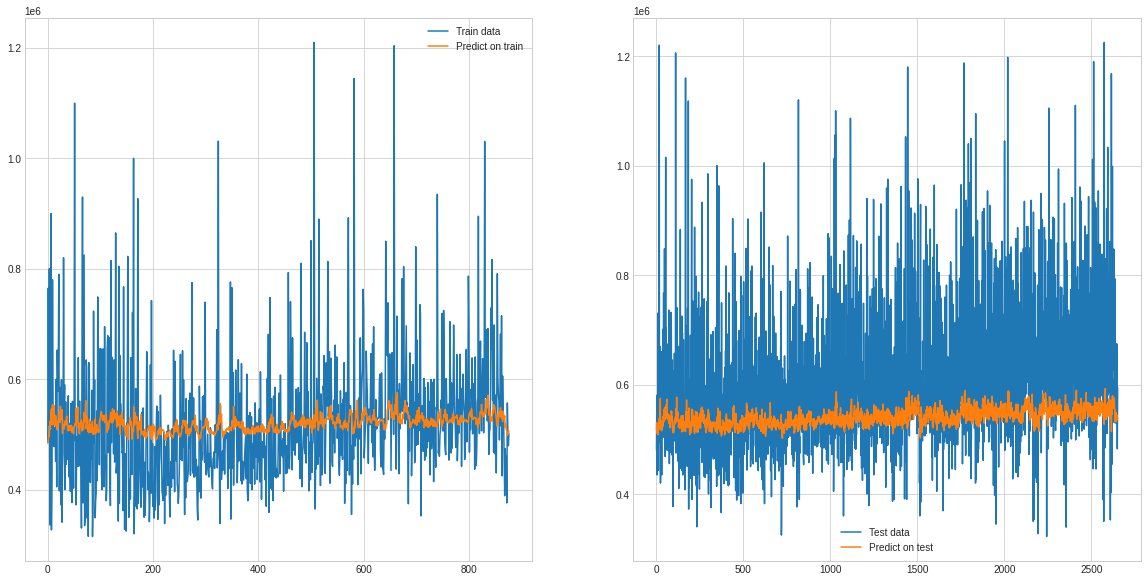

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

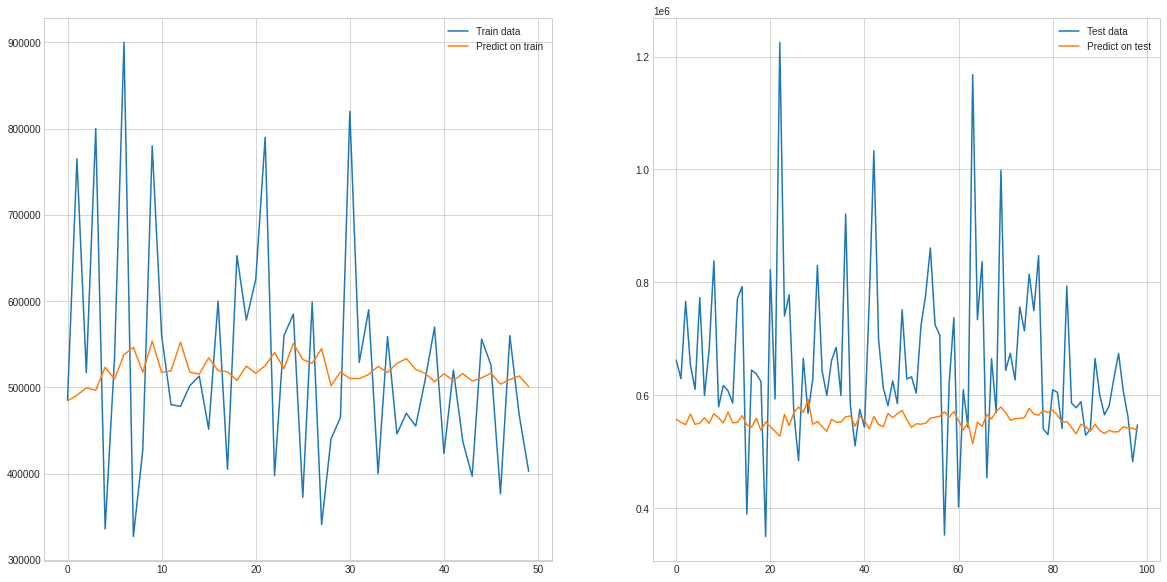

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

## Використання вікна розміру 2

### Simple RNN

In [ ]:
ts_train_X, ts_train_y = create_ts_for_rnn(ts_train,2)
ts_test_X, ts_test_y = create_ts_for_rnn(ts_test,2)

In [ ]:
model_8 = tf.keras.Sequential([
                               layers.SimpleRNN(1, input_shape = (None, 2)),
                               layers.Dense(1)
])
model_8.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_8 = model_8.fit(
      ts_train_X,
      ts_train_y,
      epochs = 20,
  )

Epoch 1/20
28/28 [==============================] - 1s 3ms/step - loss: 0.0407
Epoch 2/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0299
Epoch 3/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0232
Epoch 4/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 5/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 7/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 8/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 9/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 10/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 11/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 12/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 13/20
28/28 [==============================

In [ ]:
ts_train_y_unsc = scaler.inverse_transform(ts_train_y)
ts_test_y_unsc = scaler.inverse_transform(ts_test_y)

In [ ]:
pred_train = model_8.predict(ts_train_X)
pred_test = model_8.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 119594.07632841024
RMSE on test: 138025.02710098543
MAE on train: 85365.38683482504
MAE on test: 96661.60844972821
MAPE on train: 16.326774356916353
MAPE on test: 14.614316436266225


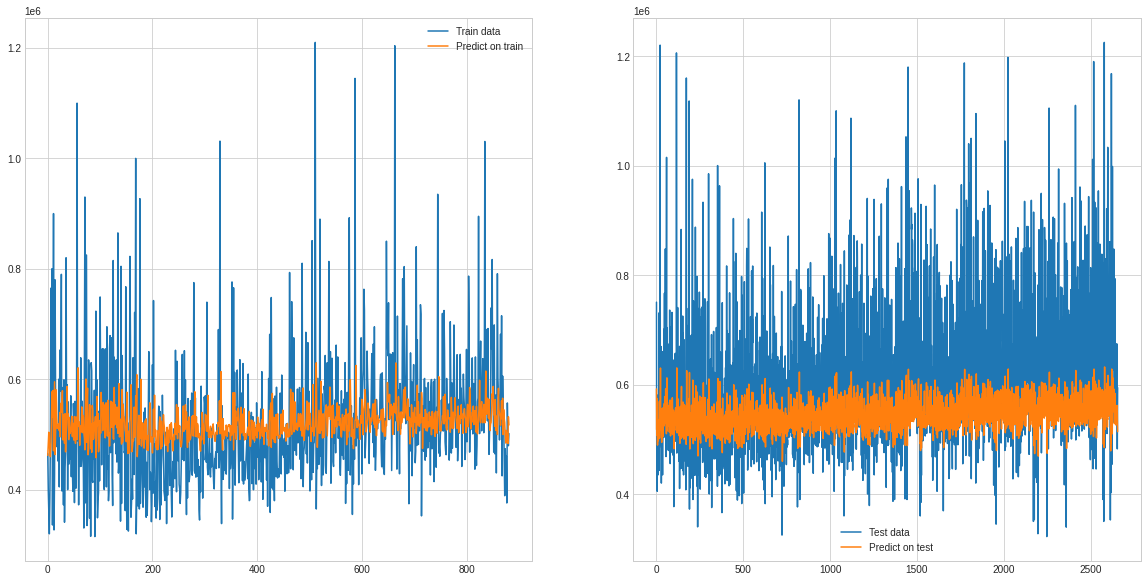

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

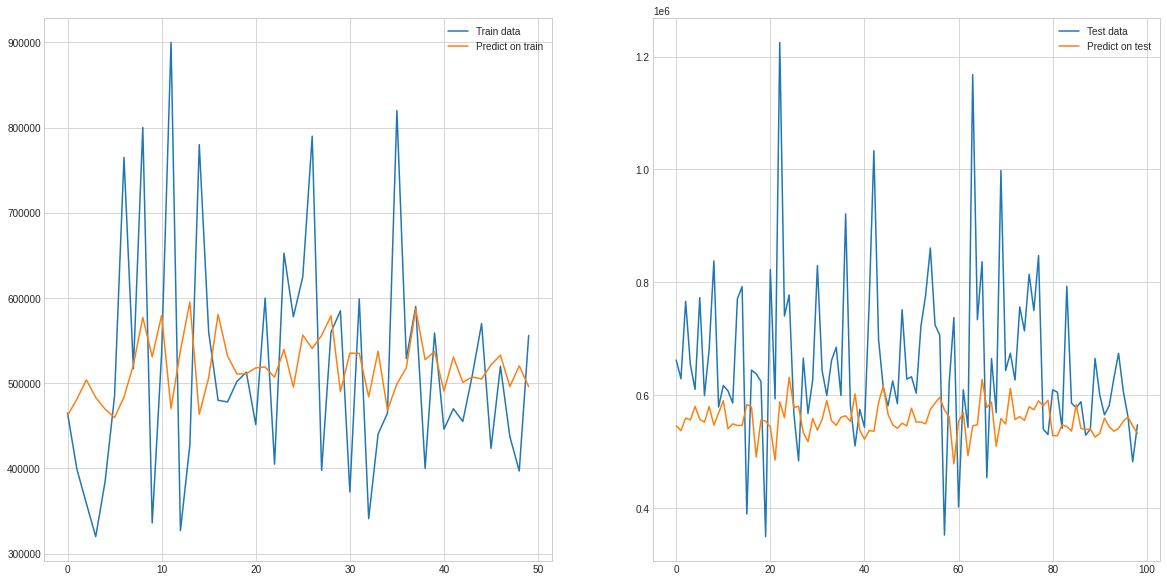

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

### LSTM

In [ ]:
model_9 = tf.keras.Sequential([
                               layers.LSTM(32, input_shape = (None, 2)),
                               layers.Dense(1)
])
model_9.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_9 = model_9.fit(
      ts_train_X,
      ts_train_y,
      epochs = 20,
  )

Epoch 1/20
28/28 [==============================] - 1s 3ms/step - loss: 0.0446
Epoch 2/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0225
Epoch 3/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 4/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 5/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 7/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 8/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 9/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 10/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 11/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 12/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 13/20
28/28 [==============================

In [ ]:
pred_train = model_9.predict(ts_train_X)
pred_test = model_9.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 117573.90646441856
RMSE on test: 141913.40901085595
MAE on train: 84795.32234754003
MAE on test: 99215.12400208687
MAPE on train: 16.2905977141271
MAPE on test: 14.797807315543404


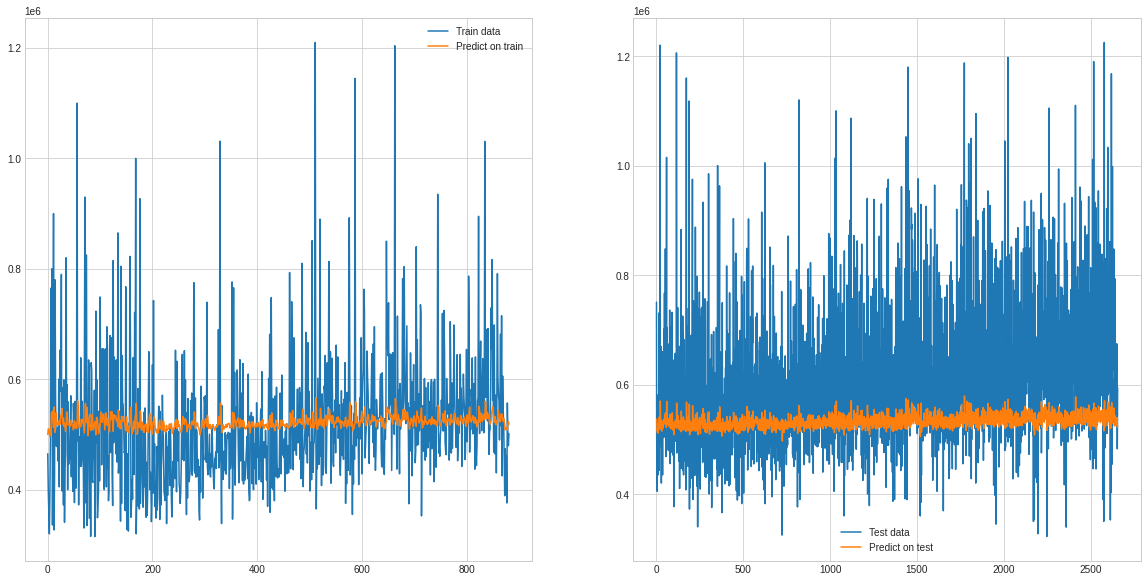

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

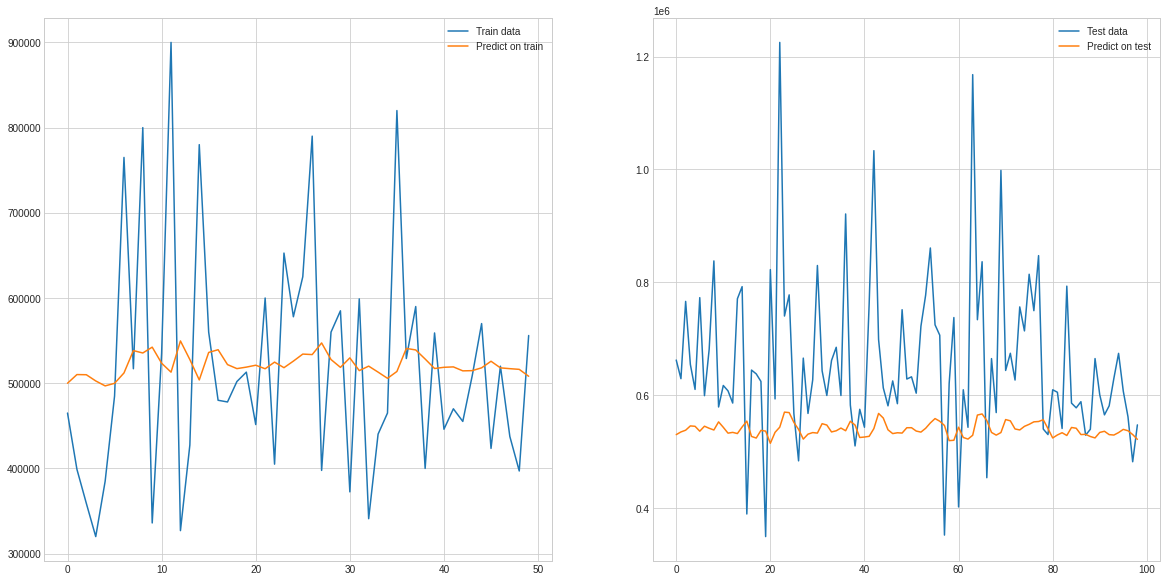

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

### GRU

In [ ]:
model_10 = tf.keras.Sequential([
                               layers.GRU(64, input_shape = (None, 2)),
                               layers.Dense(1)
])
model_10.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_10 = model_10.fit(
      ts_train_X,
      ts_train_y,
      epochs = 10,
  )

Epoch 1/10
28/28 [==============================] - 1s 3ms/step - loss: 0.0255
Epoch 2/10
28/28 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 3/10
28/28 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 4/10
28/28 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 5/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 6/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 7/10
28/28 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 8/10
28/28 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 9/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 10/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0168


In [ ]:
pred_train = model_10.predict(ts_train_X)
pred_test = model_10.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 117813.87155231042
RMSE on test: 138824.10640727344
MAE on train: 86348.69535553956
MAE on test: 96808.2328389264
MAPE on train: 16.83338350533992
MAPE on test: 14.523954583836282


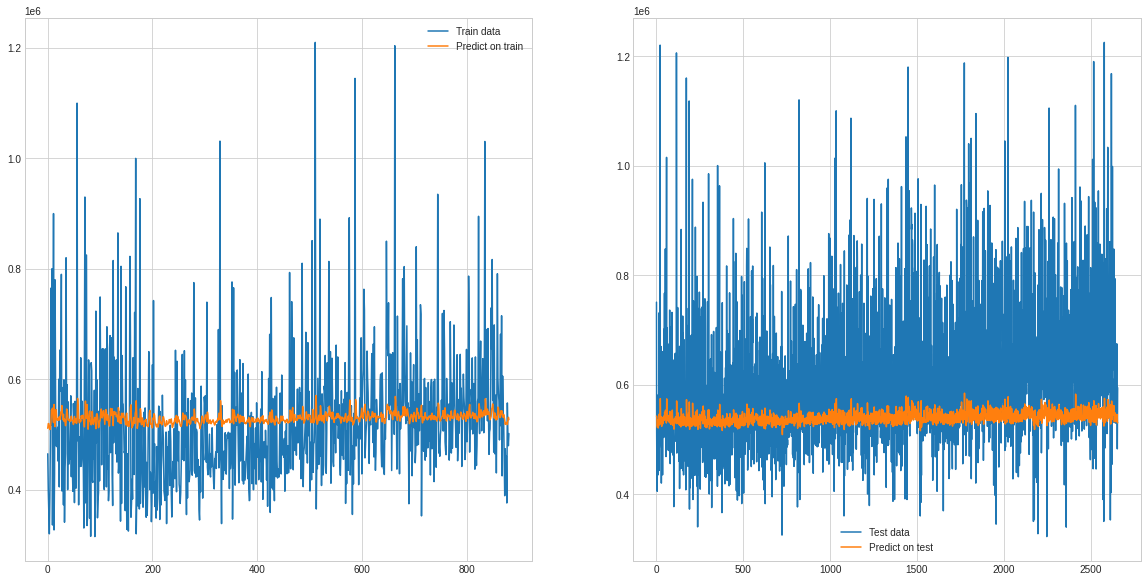

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

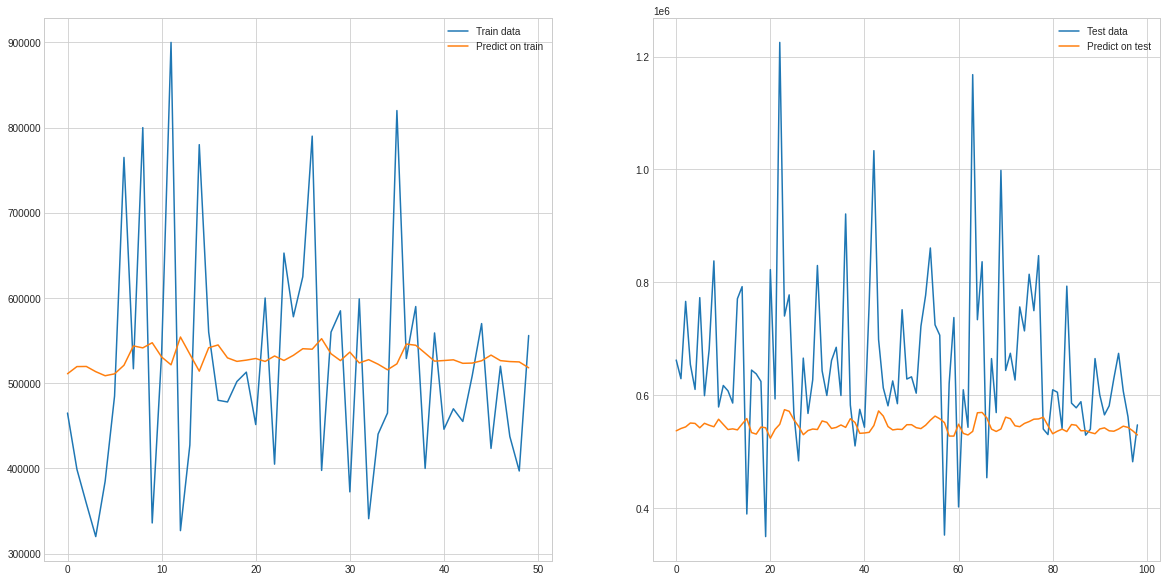

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

# Побудувати i навчити глибоку модель з декiлькома рекурентними шарами LSTM, а також глибоку модель з декiлькома шарами GRU.

## Глибока модель з LSTM

### З рекурентними дропаутами

In [ ]:
ts_train_X, ts_train_y = create_ts_for_rnn(ts_train, 7)
ts_test_X, ts_test_y = create_ts_for_rnn(ts_test, 7)

In [ ]:
model_deep_1 = tf.keras.Sequential([
                               layers.LSTM(64,input_shape = (None, 7), return_sequences=True, dropout=0.25, recurrent_dropout=0.25),
                               layers.LSTM(32,input_shape = (64,), dropout=0.25, recurrent_dropout=0.25),
                               layers.Dense(1)
])
model_deep_1.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_d1 = model_deep_1.fit(
      ts_train_X,
      ts_train_y,
      epochs = 20,
  )

Epoch 1/20
28/28 [==============================] - 4s 13ms/step - loss: 0.0424
Epoch 2/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0183
Epoch 3/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0172
Epoch 4/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0174
Epoch 5/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0172
Epoch 6/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0167
Epoch 7/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0169
Epoch 8/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0170
Epoch 9/20
28/28 [==============================] - 0s 13ms/step - loss: 0.0169
Epoch 10/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0170
Epoch 11/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0164
Epoch 12/20
28/28 [==============================] - 0s 12ms/step - loss: 0.0167
Epoch 13/20
28/28 [==================

In [ ]:
ts_train_y_unsc = scaler.inverse_transform(ts_train_y)
ts_test_y_unsc = scaler.inverse_transform(ts_test_y)

In [ ]:
pred_train = model_deep_1.predict(ts_train_X)
pred_test = model_deep_1.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 117014.85768079877
RMSE on test: 143621.7300518235
MAE on train: 84009.51263949361
MAE on test: 100371.11270684854
MAPE on train: 15.96878568556582
MAPE on test: 14.88709003512397


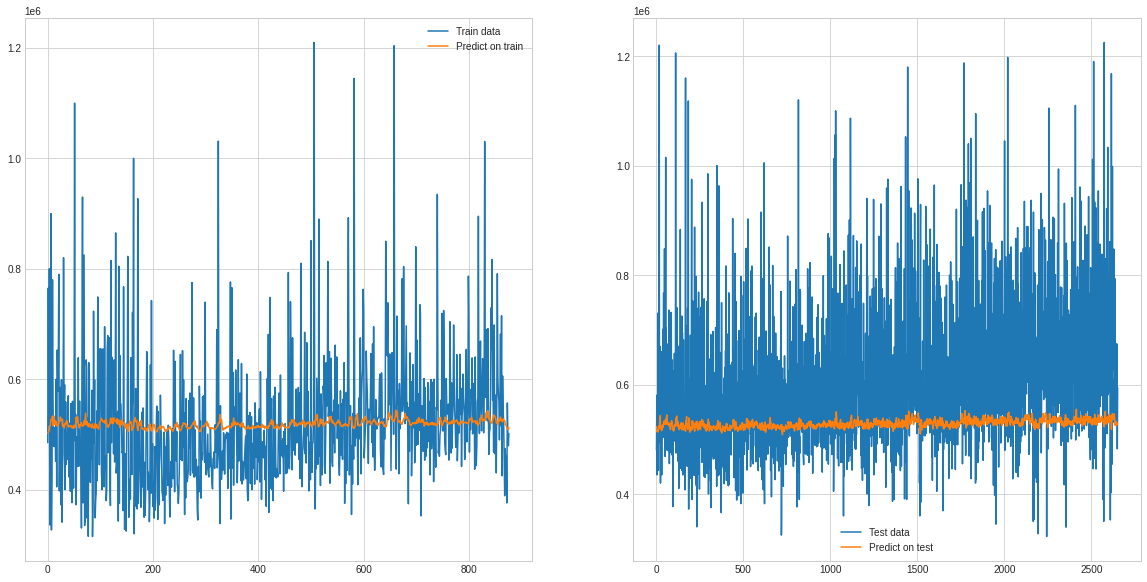

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

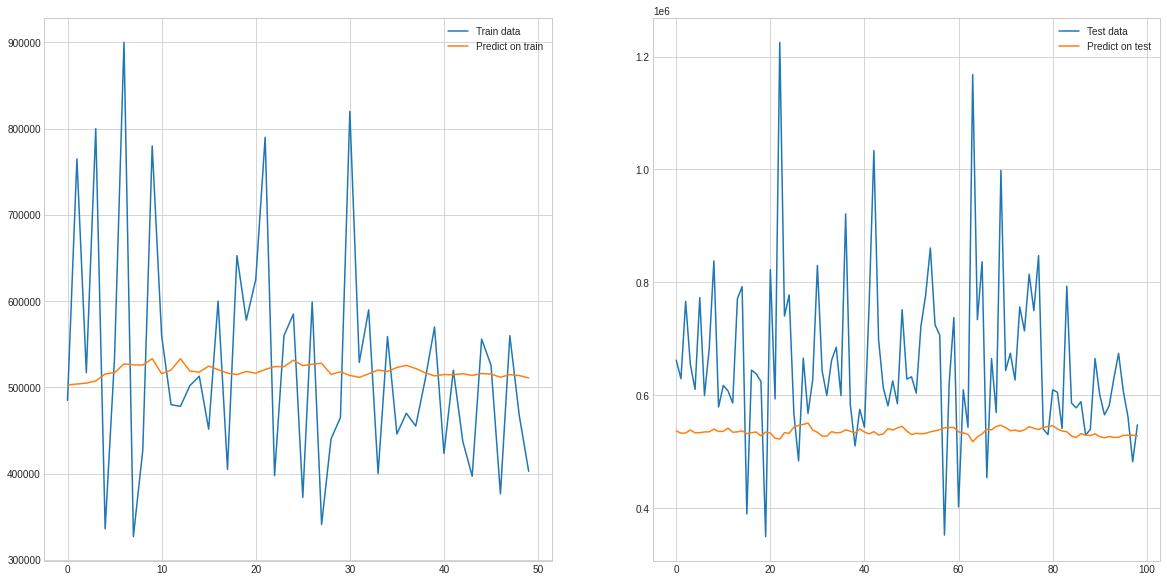

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

### Без рекурентних дропаутів

In [ ]:
model_deep_2 = tf.keras.Sequential([
                               layers.LSTM(64,input_shape = (None, 7), return_sequences=True, dropout=0.25),
                               layers.LSTM(32,input_shape = (64,), dropout=0.25),
                               layers.Dense(1)
])
model_deep_2.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_d2 = model_deep_2.fit(
      ts_train_X,
      ts_train_y,
      epochs = 20,
  )

Epoch 1/20
28/28 [==============================] - 2s 4ms/step - loss: 0.0425
Epoch 2/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0181
Epoch 3/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0179
Epoch 4/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0173
Epoch 5/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0171
Epoch 6/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0172
Epoch 7/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0171
Epoch 8/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0167
Epoch 9/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0167
Epoch 10/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0168
Epoch 11/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 12/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0169
Epoch 13/20
28/28 [==============================

In [ ]:
ts_train_y_unsc = scaler.inverse_transform(ts_train_y)
ts_test_y_unsc = scaler.inverse_transform(ts_test_y)

In [ ]:
pred_train = model_deep_2.predict(ts_train_X)
pred_test = model_deep_2.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 117339.95230987406
RMSE on test: 146346.435904449
MAE on train: 83477.41856788441
MAE on test: 102673.32604691121
MAPE on train: 15.709138614406037
MAPE on test: 15.18653144872034


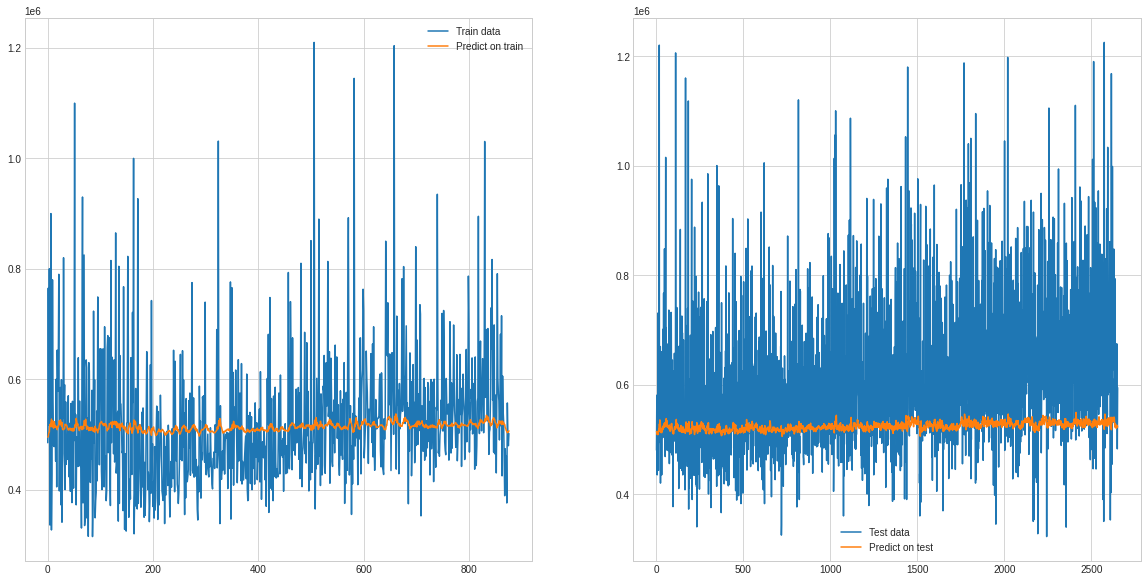

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

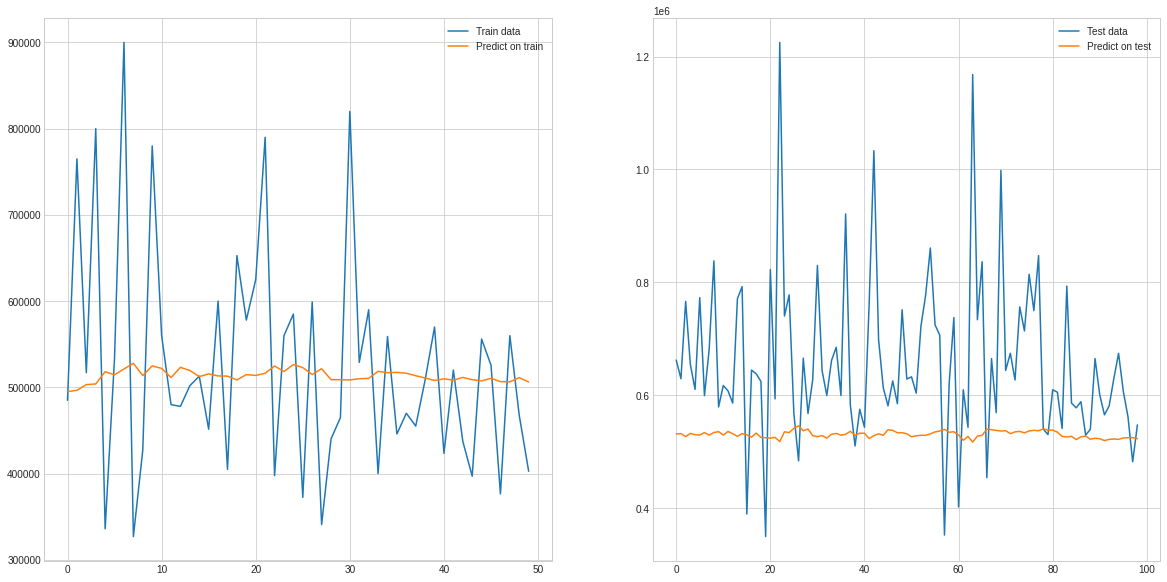

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

### Ще один глибокий шар

In [ ]:
model_deep_3 = tf.keras.Sequential([
                               layers.LSTM(128,input_shape = (None, 7), return_sequences=True, dropout=0.25, recurrent_dropout=0.25),
                               layers.LSTM(64, return_sequences=True, dropout=0.25, recurrent_dropout=0.25),
                               layers.LSTM(32,input_shape = (64,), dropout=0.25, recurrent_dropout=0.25),
                               layers.Dense(1)
])
model_deep_3.compile(loss = "mse",) #optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_d3 = model_deep_3.fit(
      ts_train_X,
      ts_train_y,
      epochs = 10,
  )

Epoch 1/10
28/28 [==============================] - 6s 19ms/step - loss: 0.0289
Epoch 2/10
28/28 [==============================] - 1s 19ms/step - loss: 0.0175
Epoch 3/10
28/28 [==============================] - 1s 18ms/step - loss: 0.0171
Epoch 4/10
28/28 [==============================] - 0s 18ms/step - loss: 0.0175
Epoch 5/10
28/28 [==============================] - 1s 18ms/step - loss: 0.0170
Epoch 6/10
28/28 [==============================] - 1s 19ms/step - loss: 0.0172
Epoch 7/10
28/28 [==============================] - 1s 18ms/step - loss: 0.0168
Epoch 8/10
28/28 [==============================] - 1s 18ms/step - loss: 0.0171
Epoch 9/10
28/28 [==============================] - 0s 18ms/step - loss: 0.0169
Epoch 10/10
28/28 [==============================] - 1s 18ms/step - loss: 0.0168


In [ ]:
pred_train = model_deep_3.predict(ts_train_X)
pred_test = model_deep_3.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 118602.64358660093
RMSE on test: 130892.53197893633
MAE on train: 89022.1513062003
MAE on test: 90987.28343275357
MAPE on train: 17.685699822267306
MAPE on test: 13.894865286201355


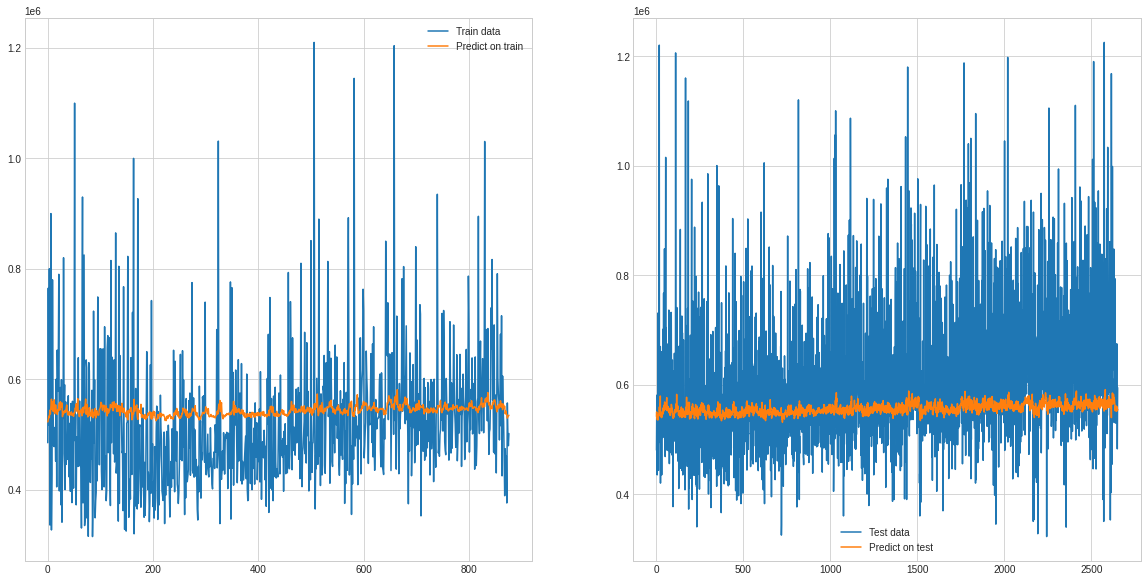

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

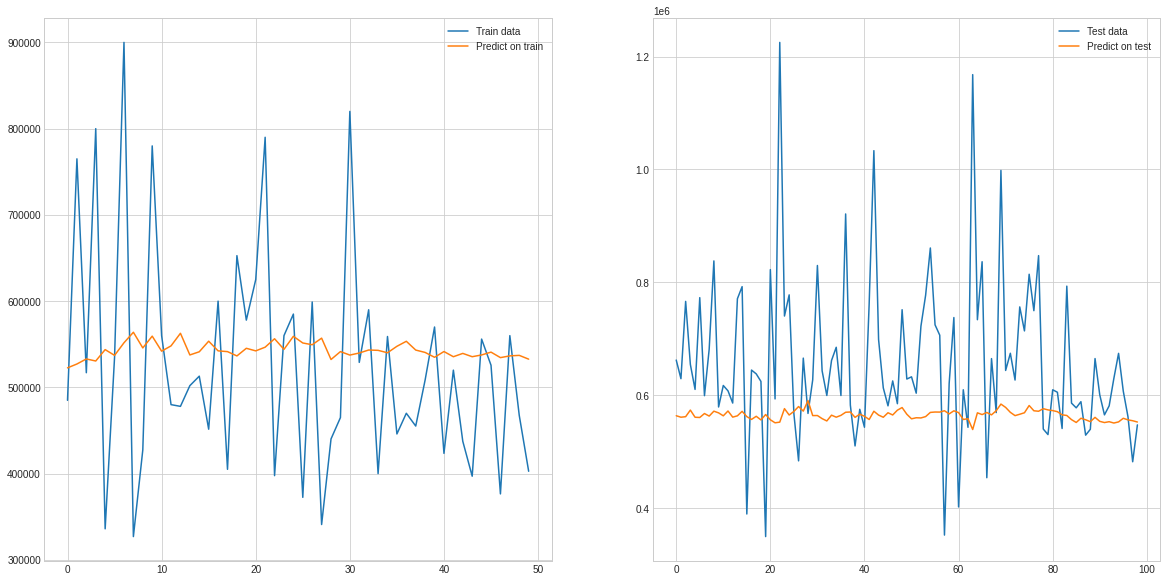

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

#### Вікно розміру 30

In [ ]:
ts_train_X, ts_train_y = create_ts_for_rnn(ts_train, 30)
ts_test_X, ts_test_y = create_ts_for_rnn(ts_test, 30)

In [ ]:
model_deep_4 = tf.keras.Sequential([
                               layers.LSTM(128,input_shape = (None, 30), return_sequences=True, dropout=0.25, recurrent_dropout=0.25),
                               layers.LSTM(64, return_sequences=True, dropout=0.25, recurrent_dropout=0.25),
                               layers.LSTM(32, dropout=0.25, recurrent_dropout=0.25),
                               layers.Dense(1)
])
model_deep_4.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_d4 = model_deep_4.fit(
      ts_train_X,
      ts_train_y,
      epochs = 20,
  )

Epoch 1/20
27/27 [==============================] - 6s 17ms/step - loss: 0.0361
Epoch 2/20
27/27 [==============================] - 0s 17ms/step - loss: 0.0166
Epoch 3/20
27/27 [==============================] - 0s 17ms/step - loss: 0.0162
Epoch 4/20
27/27 [==============================] - 0s 17ms/step - loss: 0.0164
Epoch 5/20
27/27 [==============================] - 0s 17ms/step - loss: 0.0160
Epoch 6/20
27/27 [==============================] - 0s 18ms/step - loss: 0.0154
Epoch 7/20
27/27 [==============================] - 0s 18ms/step - loss: 0.0158
Epoch 8/20
27/27 [==============================] - 0s 17ms/step - loss: 0.0158
Epoch 9/20
27/27 [==============================] - 0s 17ms/step - loss: 0.0159
Epoch 10/20
27/27 [==============================] - 0s 18ms/step - loss: 0.0156
Epoch 11/20
27/27 [==============================] - 0s 16ms/step - loss: 0.0160
Epoch 12/20
27/27 [==============================] - 0s 17ms/step - loss: 0.0159
Epoch 13/20
27/27 [==================

In [ ]:
ts_train_y_unsc = scaler.inverse_transform(ts_train_y)
ts_test_y_unsc = scaler.inverse_transform(ts_test_y)

In [ ]:
pred_train = model_deep_4.predict(ts_train_X)
pred_test = model_deep_4.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 112455.6992381939
RMSE on test: 122694.50093370228
MAE on train: 82016.48699400703
MAE on test: 86093.35280476259
MAPE on train: 15.994456170656942
MAPE on test: 13.509728473939925


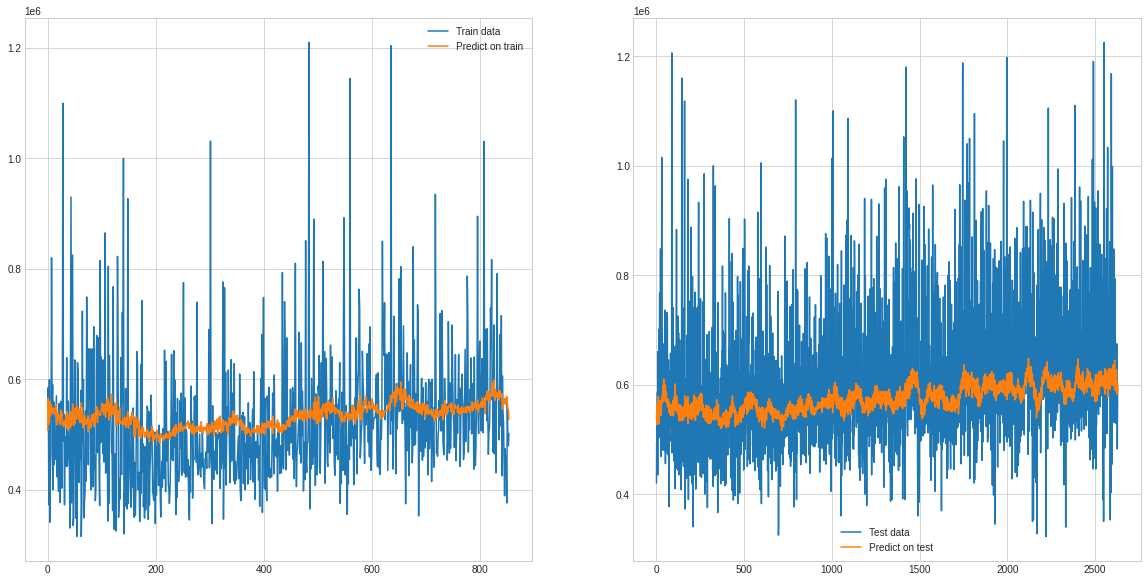

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

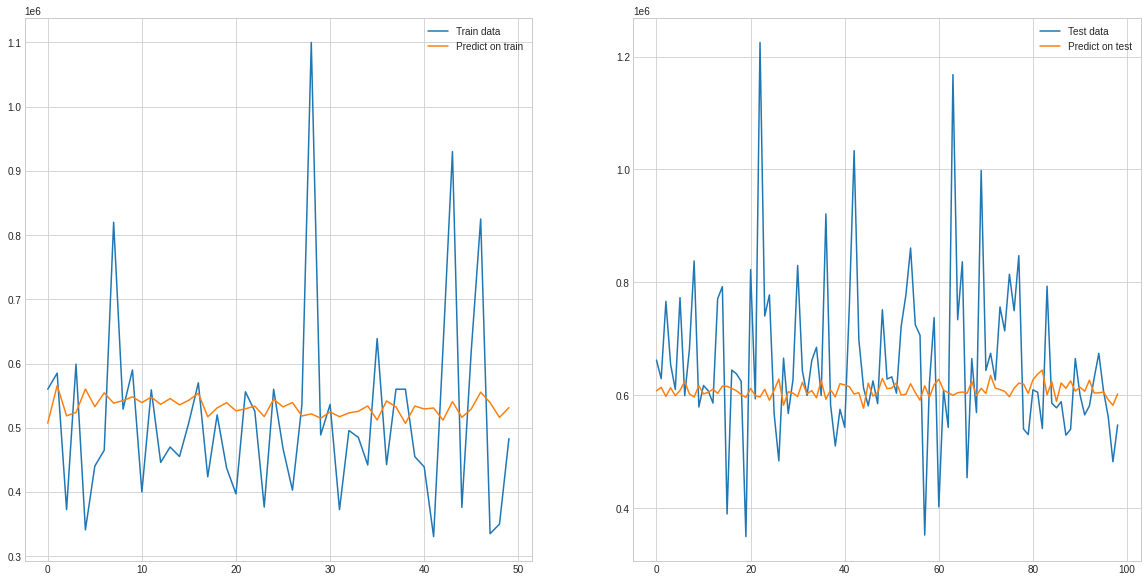

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

#### Трохи інші дропаути

In [ ]:
ts_train_X, ts_train_y = create_ts_for_rnn(ts_train, 30)
ts_test_X, ts_test_y = create_ts_for_rnn(ts_test, 30)

In [ ]:
model_deep_5 = tf.keras.Sequential([
                               layers.LSTM(240,input_shape = (None, 30), return_sequences=True,),
                               layers.Dropout(0.1),
                               layers.LSTM(120, return_sequences=True,),
                               layers.Dropout(0.1),
                               layers.LSTM(60, return_sequences=True,),
                               layers.Dropout(0.1),
                               layers.LSTM(30, dropout=0.25),
                               layers.Dropout(0.1),
                               layers.Dense(1)
])
model_deep_5.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_d5 = model_deep_5.fit(
      ts_train_X,
      ts_train_y,
      epochs = 20,
  )

Epoch 1/20
27/27 [==============================] - 4s 7ms/step - loss: 0.0370
Epoch 2/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0161
Epoch 3/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0163
Epoch 4/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0162
Epoch 5/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0161
Epoch 6/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 7/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0162
Epoch 8/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0158
Epoch 9/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0155
Epoch 10/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0158
Epoch 11/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0156
Epoch 12/20
27/27 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 13/20
27/27 [==============================

In [ ]:
ts_train_y_unsc = scaler.inverse_transform(ts_train_y)
ts_test_y_unsc = scaler.inverse_transform(ts_test_y)

In [ ]:
pred_train = model_deep_5.predict(ts_train_X)
pred_test = model_deep_5.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 111520.3621723186
RMSE on test: 120158.32372523424
MAE on train: 82073.62193845613
MAE on test: 86971.11185251511
MAPE on train: 16.037558836182974
MAPE on test: 14.021601801181372


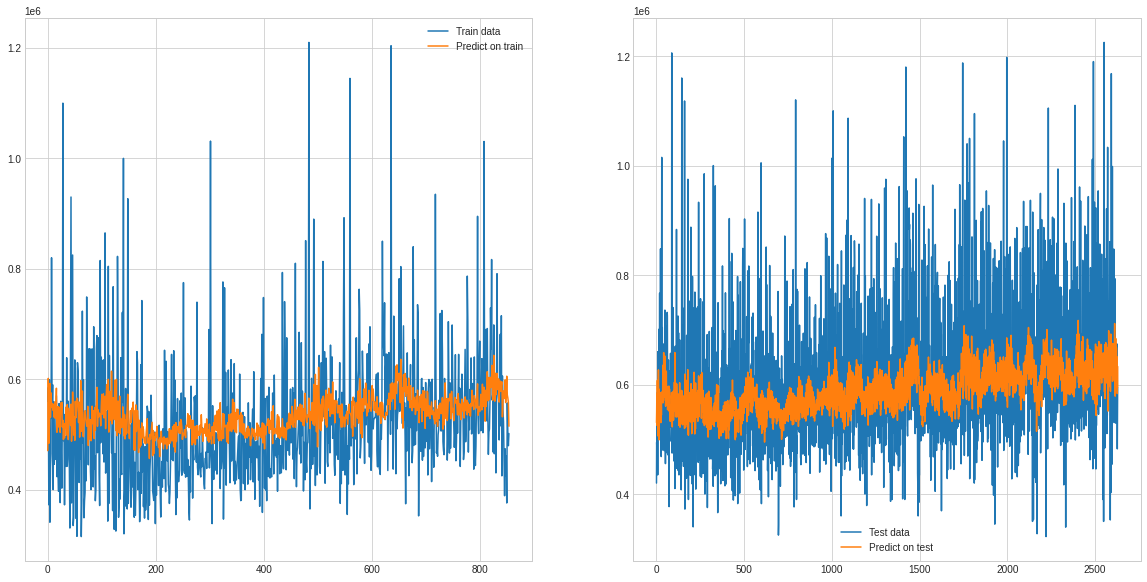

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

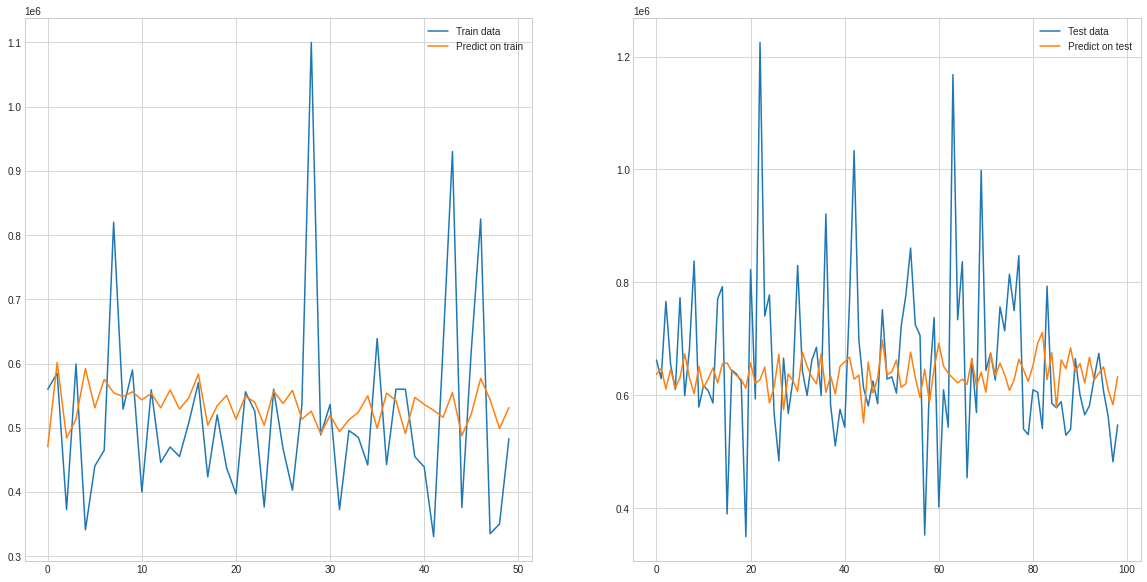

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

## Глибокі моделі з GRU

### Із рекурентними дропаутами

In [ ]:
model_gru_1 = tf.keras.Sequential([
                               layers.GRU(128, return_sequences=True, dropout=0.25, 
                                          recurrent_dropout=0.25, input_shape = (None, 7)),
                               layers.GRU(64, dropout=0.25, 
                                          recurrent_dropout=0.25,),
                               layers.Dense(1)
])
model_gru_1.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_gru_1 = model_gru_1.fit(
      ts_train_X,
      ts_train_y,
      epochs = 10,
  )

Epoch 1/10
28/28 [==============================] - 3s 11ms/step - loss: 0.0264
Epoch 2/10
28/28 [==============================] - 0s 11ms/step - loss: 0.0178
Epoch 3/10
28/28 [==============================] - 0s 11ms/step - loss: 0.0171
Epoch 4/10
28/28 [==============================] - 0s 10ms/step - loss: 0.0169
Epoch 5/10
28/28 [==============================] - 0s 10ms/step - loss: 0.0170
Epoch 6/10
28/28 [==============================] - 0s 11ms/step - loss: 0.0170
Epoch 7/10
28/28 [==============================] - 0s 11ms/step - loss: 0.0168
Epoch 8/10
28/28 [==============================] - 0s 11ms/step - loss: 0.0169
Epoch 9/10
28/28 [==============================] - 0s 11ms/step - loss: 0.0170
Epoch 10/10
28/28 [==============================] - 0s 11ms/step - loss: 0.0167


In [ ]:
pred_train = model_gru_1.predict(ts_train_X)
pred_test = model_gru_1.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 116898.65486503404
RMSE on test: 140340.4421512089
MAE on train: 84511.93367372826
MAE on test: 97731.7727205575
MAPE on train: 16.200233731232167
MAPE on test: 14.56336930641488


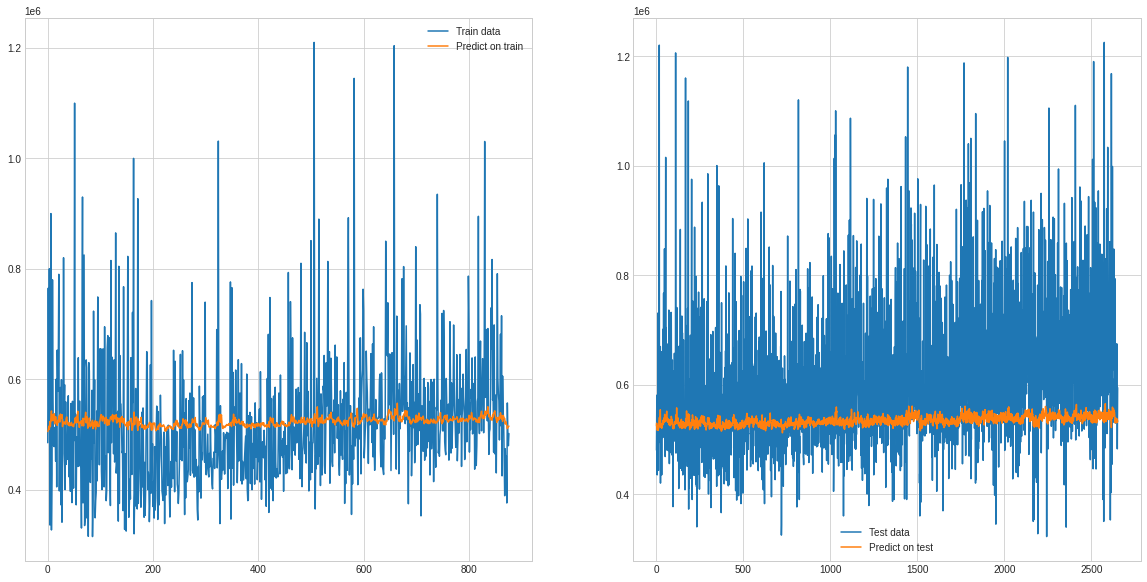

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

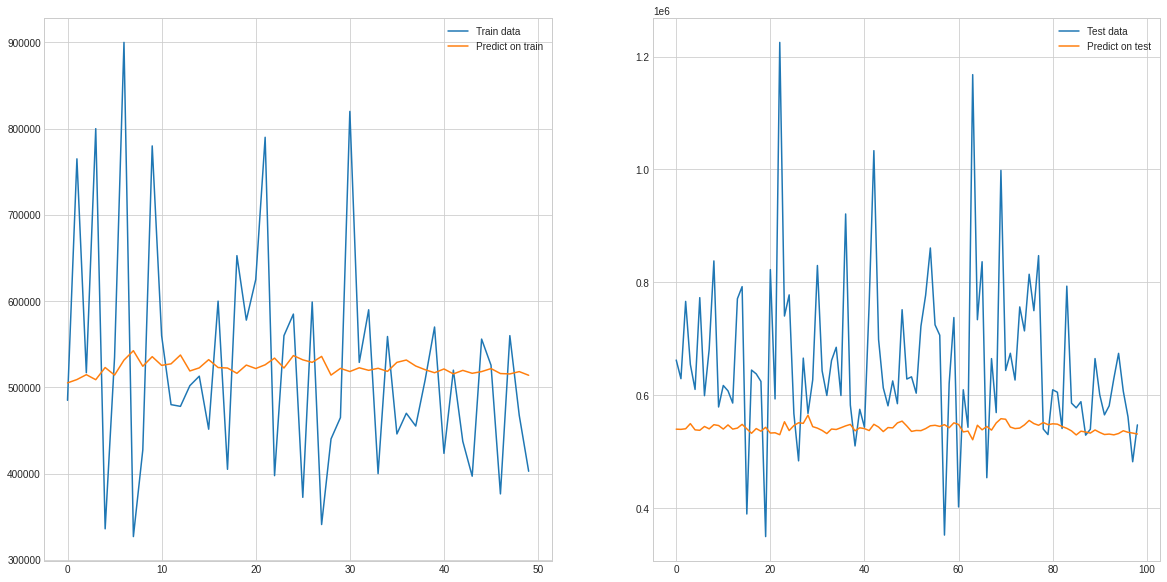

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

### Без рекурентних дропаутів

In [ ]:
model_gru_2 = tf.keras.Sequential([
                               layers.GRU(128, return_sequences=True, dropout=0.25, input_shape = (None, 7)),
                               layers.GRU(64, dropout=0.25,),
                               layers.Dense(1)
])
model_gru_2.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_gru_2 = model_gru_2.fit(
      ts_train_X,
      ts_train_y,
      epochs = 10,
  )

Epoch 1/10
28/28 [==============================] - 2s 4ms/step - loss: 0.0234
Epoch 2/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 3/10
28/28 [==============================] - 0s 4ms/step - loss: 0.0174
Epoch 4/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 5/10
28/28 [==============================] - 0s 4ms/step - loss: 0.0168
Epoch 6/10
28/28 [==============================] - 0s 4ms/step - loss: 0.0171
Epoch 7/10
28/28 [==============================] - 0s 4ms/step - loss: 0.0168
Epoch 8/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 9/10
28/28 [==============================] - 0s 4ms/step - loss: 0.0168
Epoch 10/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0171


In [ ]:
pred_train = model_gru_2.predict(ts_train_X)
pred_test = model_gru_2.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 117254.70355249086
RMSE on test: 135913.98030356131
MAE on train: 86173.25687807996
MAE on test: 94309.14930123737
MAPE on train: 16.80621535430153
MAPE on test: 14.197188754376


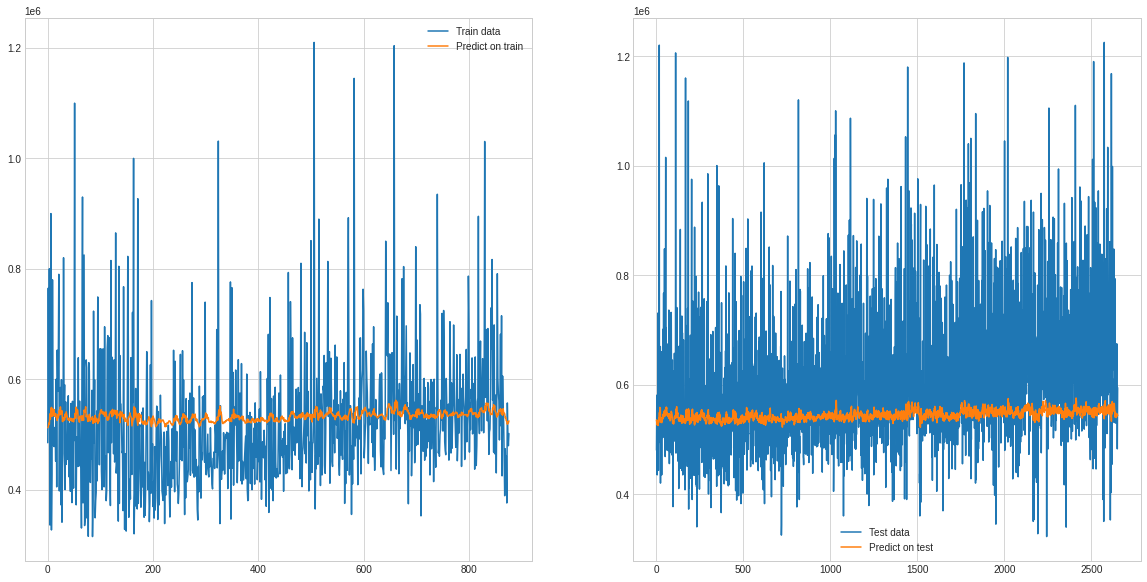

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

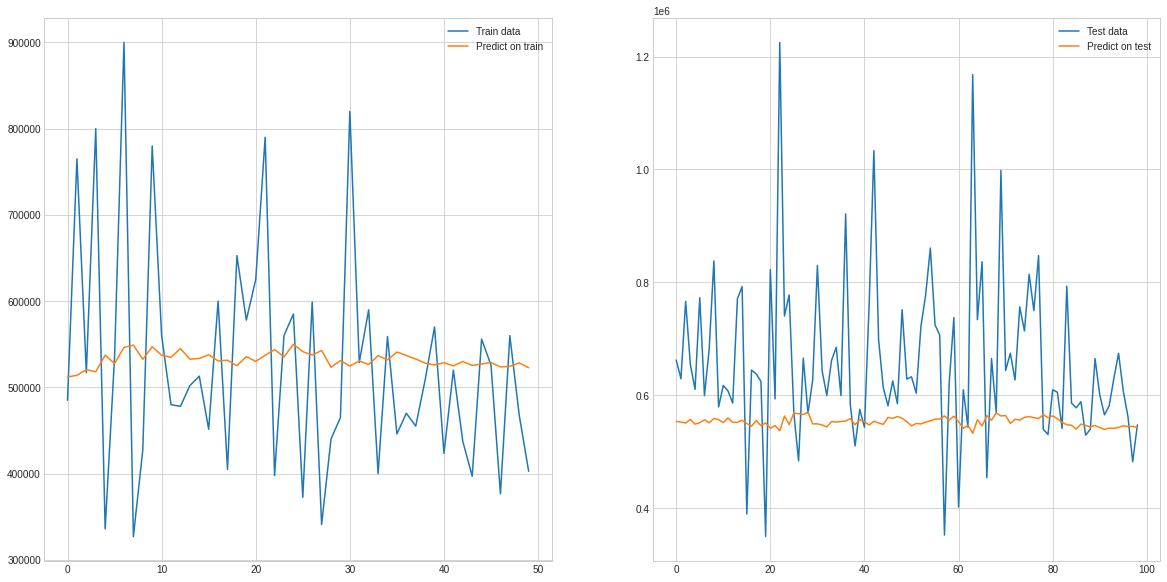

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

### Ще декілька шарів прихованих

In [ ]:
model_gru_3 = tf.keras.Sequential([
                               layers.GRU(56, return_sequences=True, dropout=0.25, input_shape = (None, 7)),
                               layers.GRU(28, return_sequences=True, dropout=0.25,),
                               layers.GRU(14, return_sequences=True, dropout=0.25,),
                               layers.GRU(7, dropout=0.25,),
                               layers.Dense(1)
])
model_gru_3.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_gru_3 = model_gru_3.fit(
      ts_train_X,
      ts_train_y,
      epochs = 12,
  )

Epoch 1/12
28/28 [==============================] - 5s 6ms/step - loss: 0.0339
Epoch 2/12
28/28 [==============================] - 0s 6ms/step - loss: 0.0185
Epoch 3/12
28/28 [==============================] - 0s 6ms/step - loss: 0.0172
Epoch 4/12
28/28 [==============================] - 0s 6ms/step - loss: 0.0175
Epoch 5/12
28/28 [==============================] - 0s 6ms/step - loss: 0.0170
Epoch 6/12
28/28 [==============================] - 0s 6ms/step - loss: 0.0172
Epoch 7/12
28/28 [==============================] - 0s 6ms/step - loss: 0.0174
Epoch 8/12
28/28 [==============================] - 0s 6ms/step - loss: 0.0168
Epoch 9/12
28/28 [==============================] - 0s 6ms/step - loss: 0.0168
Epoch 10/12
28/28 [==============================] - 0s 6ms/step - loss: 0.0171
Epoch 11/12
28/28 [==============================] - 0s 6ms/step - loss: 0.0169
Epoch 12/12
28/28 [==============================] - 0s 6ms/step - loss: 0.0170


In [ ]:
pred_train = model_gru_3.predict(ts_train_X)
pred_test = model_gru_3.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 117256.12469327333
RMSE on test: 146311.89966793876
MAE on train: 84032.99027695024
MAE on test: 102799.06100262923
MAPE on train: 15.940180219048782
MAPE on test: 15.213313048593402


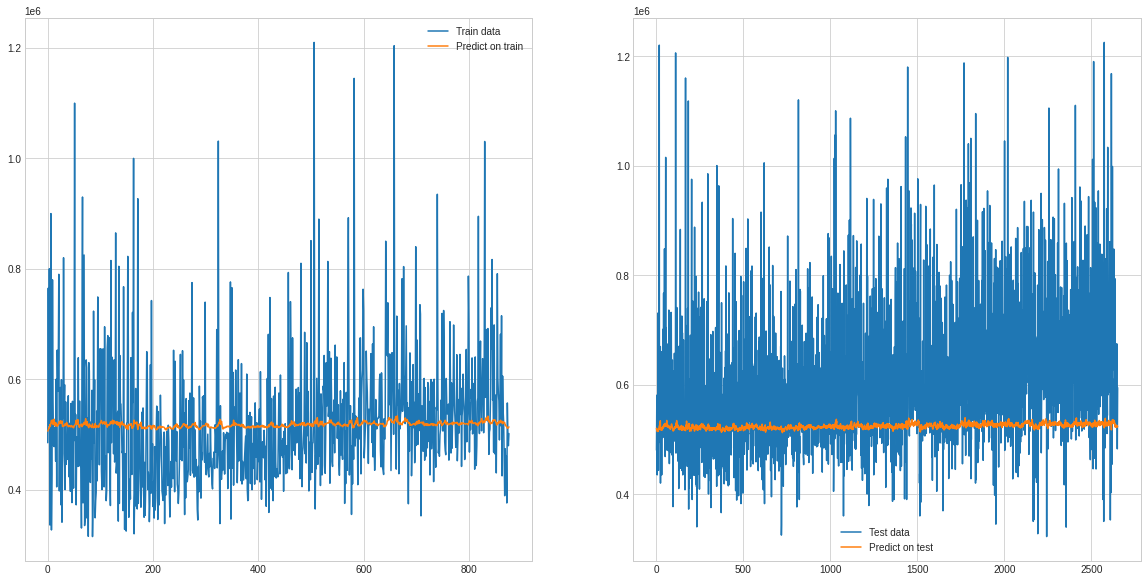

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

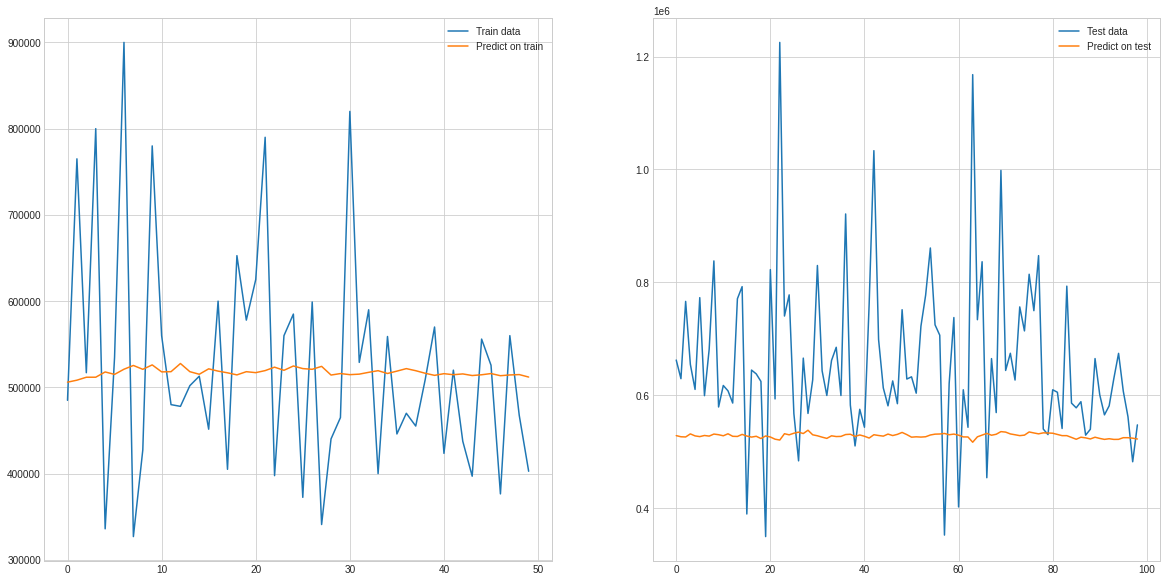

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

#### Вікно розміру 30

In [ ]:
ts_train_X, ts_train_y = create_ts_for_rnn(ts_train, 30)
ts_test_X, ts_test_y = create_ts_for_rnn(ts_test, 30)

In [ ]:
model_gru_4 = tf.keras.Sequential([
                               layers.GRU(56, return_sequences=True,recurrent_dropout=.25, dropout=0.25, input_shape = (None, 30)),
                               layers.GRU(28, return_sequences=True,recurrent_dropout=.25, dropout=0.25,),
                               layers.GRU(14, return_sequences=True,recurrent_dropout=.25, dropout=0.25,),
                               layers.GRU(7, dropout=0.25,),
                               layers.Dense(1)
])
model_gru_4.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_gru_4 = model_gru_4.fit(
      ts_train_X,
      ts_train_y,
      epochs = 12,
  )

Epoch 1/12
27/27 [==============================] - 6s 18ms/step - loss: 0.0330
Epoch 2/12
27/27 [==============================] - 0s 17ms/step - loss: 0.0183
Epoch 3/12
27/27 [==============================] - 0s 17ms/step - loss: 0.0175
Epoch 4/12
27/27 [==============================] - 0s 17ms/step - loss: 0.0170
Epoch 5/12
27/27 [==============================] - 0s 17ms/step - loss: 0.0170
Epoch 6/12
27/27 [==============================] - 0s 16ms/step - loss: 0.0165
Epoch 7/12
27/27 [==============================] - 0s 16ms/step - loss: 0.0165
Epoch 8/12
27/27 [==============================] - 0s 17ms/step - loss: 0.0166
Epoch 9/12
27/27 [==============================] - 0s 16ms/step - loss: 0.0165
Epoch 10/12
27/27 [==============================] - 0s 17ms/step - loss: 0.0163
Epoch 11/12
27/27 [==============================] - 0s 16ms/step - loss: 0.0163
Epoch 12/12
27/27 [==============================] - 0s 16ms/step - loss: 0.0162


In [ ]:
pred_train = model_gru_4.predict(ts_train_X)
pred_test = model_gru_4.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 113860.29561009083
RMSE on test: 138549.03139518158
MAE on train: 81169.88868735662
MAE on test: 96443.30046076866
MAPE on train: 15.410612994567247
MAPE on test: 14.386902025128832


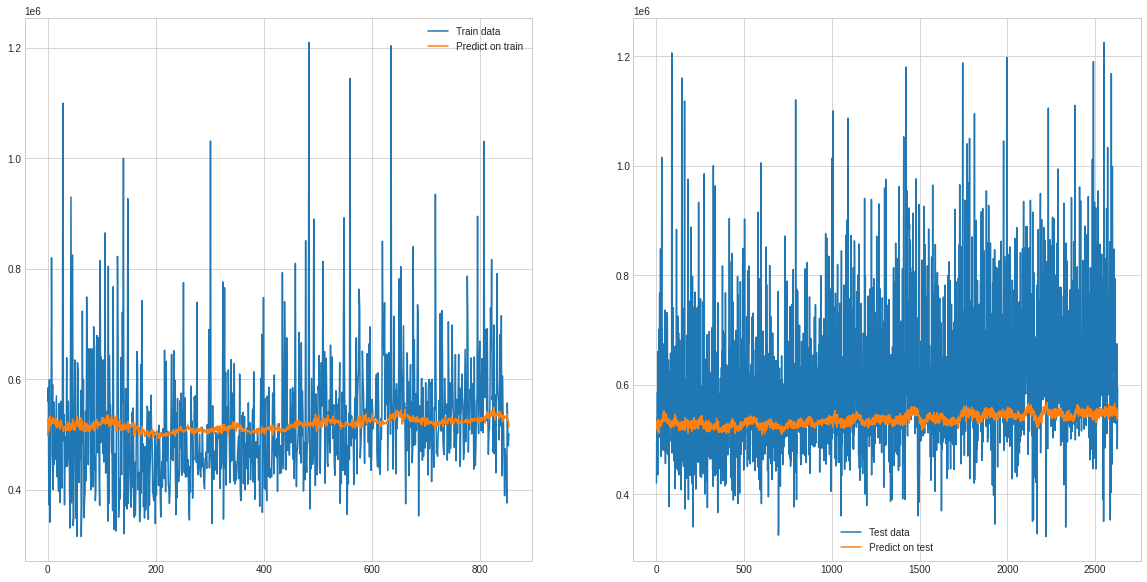

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

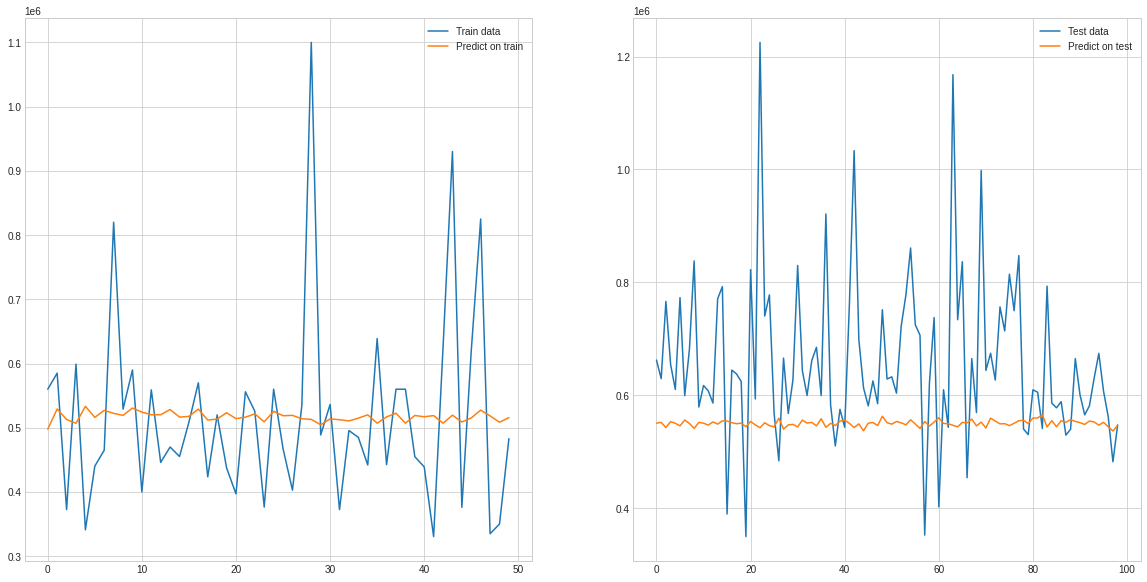

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

#### Трохи інші параметри для дропів

In [ ]:
model_gru_5 = tf.keras.Sequential([
                               layers.GRU(56, return_sequences=True, input_shape = (None, 30)),
                               layers.Dropout(0.1),
                               layers.GRU(28, return_sequences=True),
                               layers.Dropout(0.1),
                               layers.GRU(14, return_sequences=True),
                               layers.Dropout(0.1),
                               layers.GRU(7),
                               layers.Dropout(0.1),
                               layers.Dense(1)
])
model_gru_5.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_gru_5 = model_gru_5.fit(
      ts_train_X,
      ts_train_y,
      epochs = 12,
  )

Epoch 1/12
27/27 [==============================] - 5s 6ms/step - loss: 0.0315
Epoch 2/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0184
Epoch 3/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0166
Epoch 4/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0172
Epoch 5/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0169
Epoch 6/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0170
Epoch 7/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0169
Epoch 8/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0167
Epoch 9/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0166
Epoch 10/12
27/27 [==============================] - 0s 7ms/step - loss: 0.0164
Epoch 11/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0158
Epoch 12/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0162


In [ ]:
pred_train = model_gru_5.predict(ts_train_X)
pred_test = model_gru_5.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 112883.15230427436
RMSE on test: 135243.06066099586
MAE on train: 79579.64091949946
MAE on test: 93677.21540244136
MAPE on train: 14.902257387255396
MAPE on test: 14.044330430396187


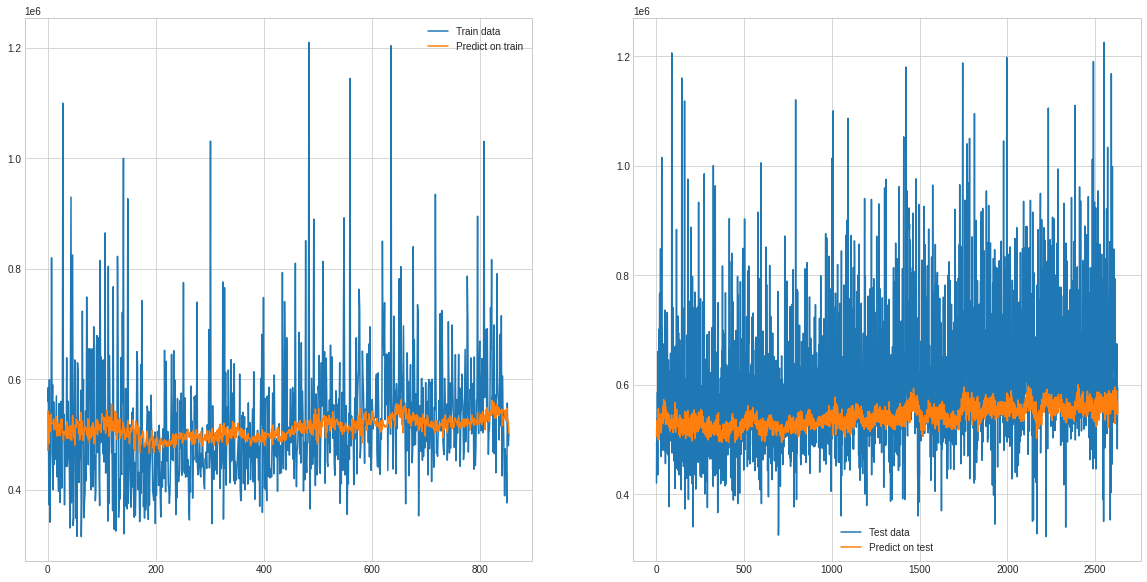

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

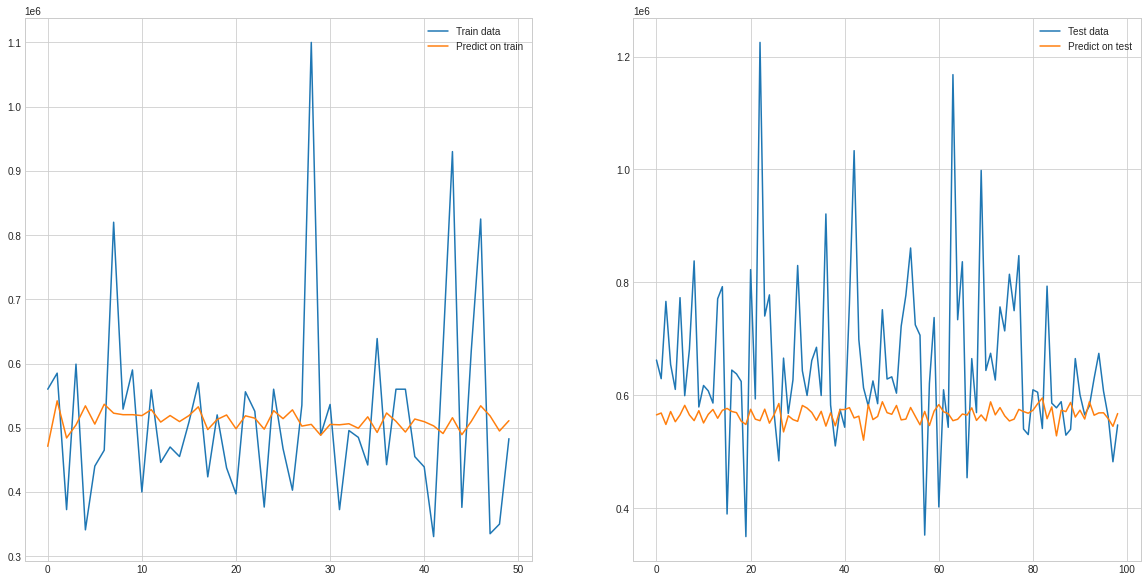

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

## Мікс GRU і LSTM

In [ ]:
model_gru_lstm = tf.keras.Sequential([
                               layers.GRU(240, return_sequences=True, input_shape = (None, 30)),
                               layers.Dropout(0.1),
                               layers.LSTM(120, return_sequences=True),
                               layers.Dropout(0.1),
                               layers.GRU(60, return_sequences=True),
                               layers.Dropout(0.1),
                               layers.LSTM(30),
                               layers.Dropout(0.1),
                               layers.Dense(1)
])
model_gru_lstm.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_gru_lstm = model_gru_lstm.fit(
      ts_train_X,
      ts_train_y,
      epochs = 12,
  )

Epoch 1/12
27/27 [==============================] - 4s 6ms/step - loss: 0.0307
Epoch 2/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0163
Epoch 3/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0161
Epoch 4/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0156
Epoch 5/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0160
Epoch 6/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0156
Epoch 7/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0155
Epoch 8/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0156
Epoch 9/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0156
Epoch 10/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0158
Epoch 11/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0155
Epoch 12/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0154


In [ ]:
pred_train = model_gru_lstm.predict(ts_train_X)
pred_test = model_gru_lstm.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 112697.80045836559
RMSE on test: 118979.06801496279
MAE on train: 84171.60658275158
MAE on test: 87357.6395500378
MAPE on train: 16.655702843789918
MAPE on test: 14.300954926434756


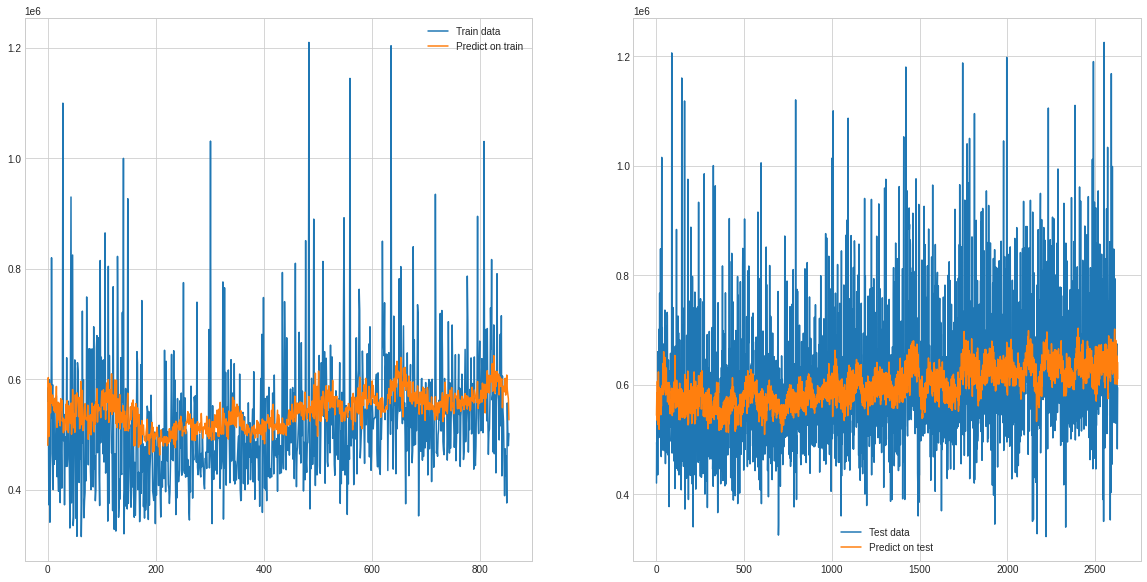

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

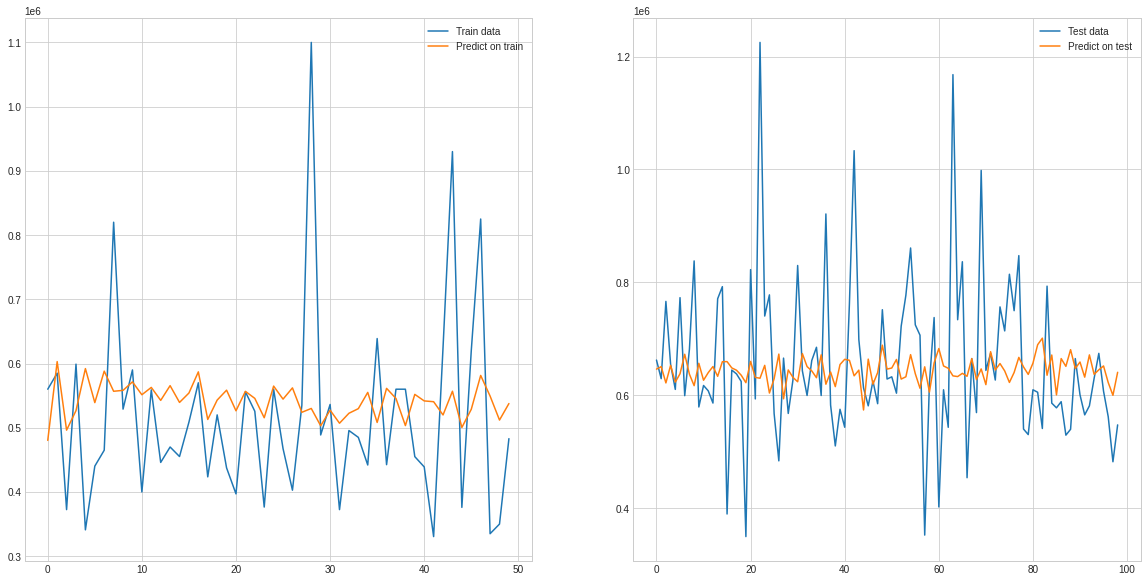

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

## Мікс GRU і LSTM v. 2.0

In [ ]:
model_gru_lstm_2 = tf.keras.Sequential([
                               layers.GRU(240, return_sequences=True, input_shape = (None, 30)),
                               layers.Dropout(0.1),
                               layers.LSTM(120),
                               layers.Dropout(0.1),
                               layers.Dense(1)
])
model_gru_lstm_2.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_gru_lstm_2 = model_gru_lstm_2.fit(
      ts_train_X,
      ts_train_y,
      epochs = 12,
  )

Epoch 1/12
27/27 [==============================] - 2s 4ms/step - loss: 0.0227
Epoch 2/12
27/27 [==============================] - 0s 4ms/step - loss: 0.0159
Epoch 3/12
27/27 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 4/12
27/27 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 5/12
27/27 [==============================] - 0s 4ms/step - loss: 0.0150
Epoch 6/12
27/27 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 7/12
27/27 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 8/12
27/27 [==============================] - 0s 4ms/step - loss: 0.0151
Epoch 9/12
27/27 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 10/12
27/27 [==============================] - 0s 4ms/step - loss: 0.0156
Epoch 11/12
27/27 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 12/12
27/27 [==============================] - 0s 4ms/step - loss: 0.0153


In [ ]:
pred_train = model_gru_lstm_2.predict(ts_train_X)
pred_test = model_gru_lstm_2.predict(ts_test_X)
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 111312.20137559244
RMSE on test: 120056.47517388444
MAE on train: 81492.00996480735
MAE on test: 86568.27860072759
MAPE on train: 15.866848091895868
MAPE on test: 13.932912304824423


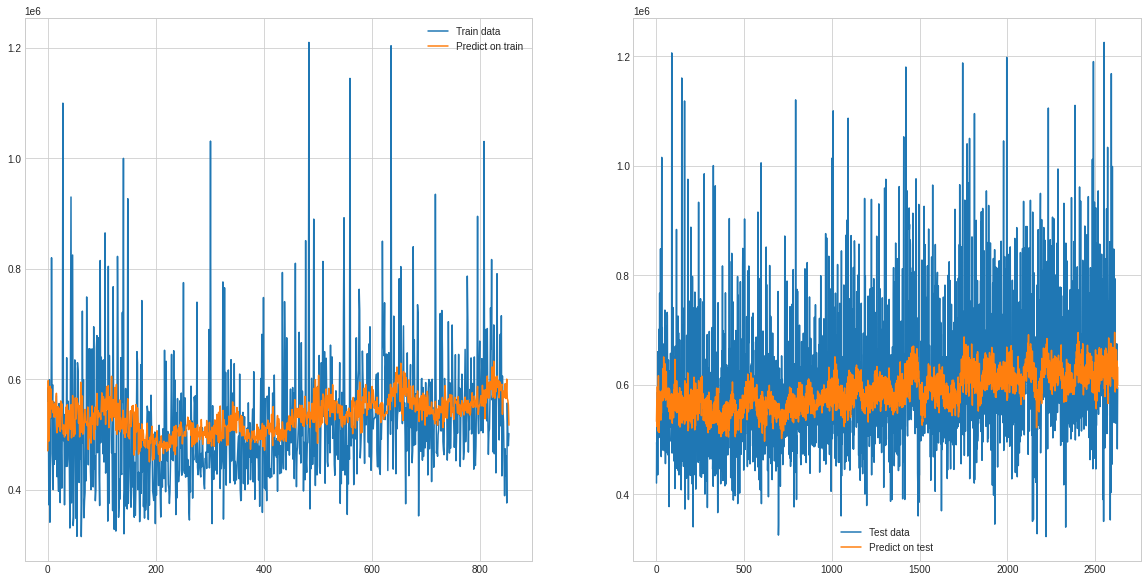

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

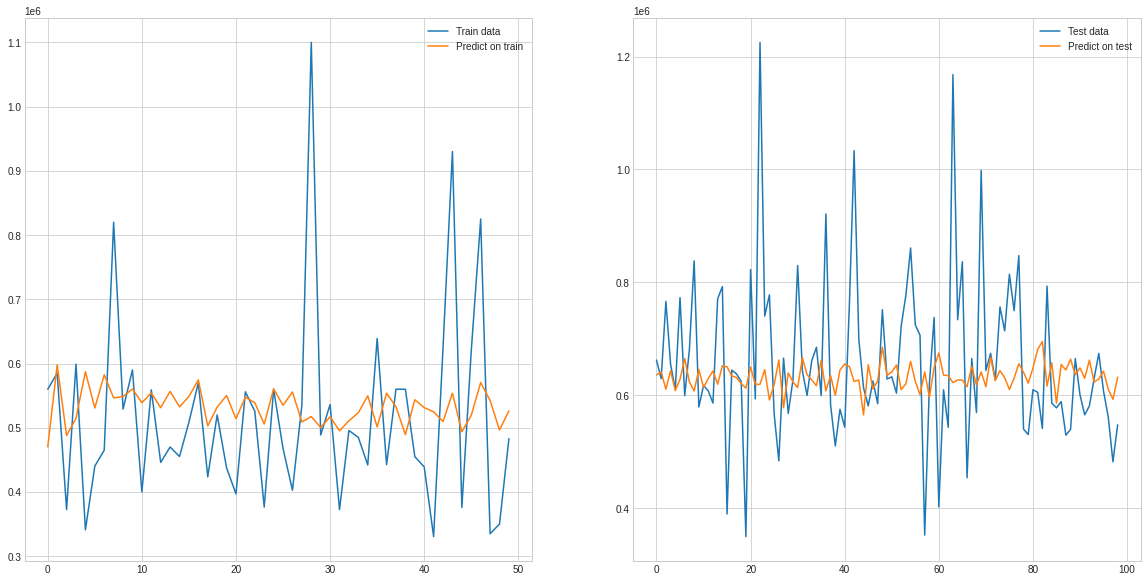

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

# Побудувати i навчити глибоку модель зi згортковими шарами conv1D та шарами max_pool1D

In [ ]:
model_conv_1 = tf.keras.Sequential([
                                  layers.InputLayer((30, 1)),
                                  layers.Conv1D(30, 3, padding="same"),
                                  layers.MaxPool1D(2),
                                  layers.Dropout(0.1),
                                  layers.Conv1D(60, 3, padding="same"),
                                  layers.MaxPool1D(2),
                                  layers.Dropout(0.1),
                                  layers.Flatten(),
                                  layers.Dense(1)
                               
])
model_conv_1.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_conv_1 = model_conv_1.fit(
      ts_train_X.reshape(len(ts_train_X), 30, 1),
      ts_train_y,
      epochs = 12,
  )

Epoch 1/12
27/27 [==============================] - 0s 3ms/step - loss: 0.0191
Epoch 2/12
27/27 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 3/12
27/27 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 4/12
27/27 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 5/12
27/27 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 6/12
27/27 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 7/12
27/27 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 8/12
27/27 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 9/12
27/27 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 10/12
27/27 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 11/12
27/27 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 12/12
27/27 [==============================] - 0s 2ms/step - loss: 0.0141


In [ ]:
pred_train = model_conv_1.predict(ts_train_X.reshape(len(ts_train_X), 30, 1))
pred_test = model_conv_1.predict(ts_test_X.reshape(len(ts_test_X), 30, 1))
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 104829.964329074
RMSE on test: 121336.6246849389
MAE on train: 76324.92032138901
MAE on test: 88592.1136266871
MAPE on train: 14.77876741172513
MAPE on test: 14.463260039599671


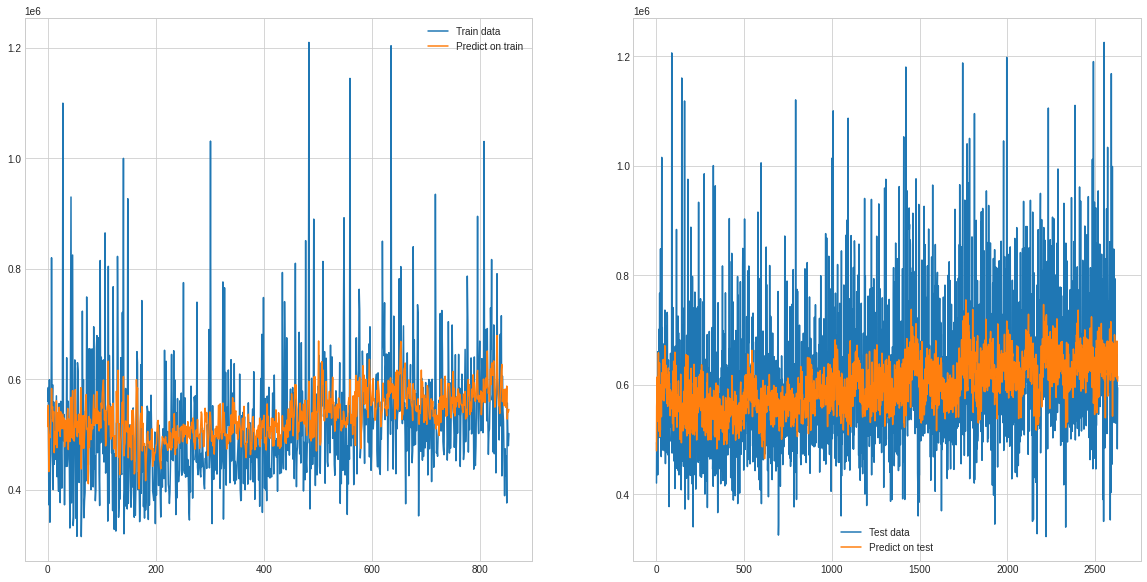

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

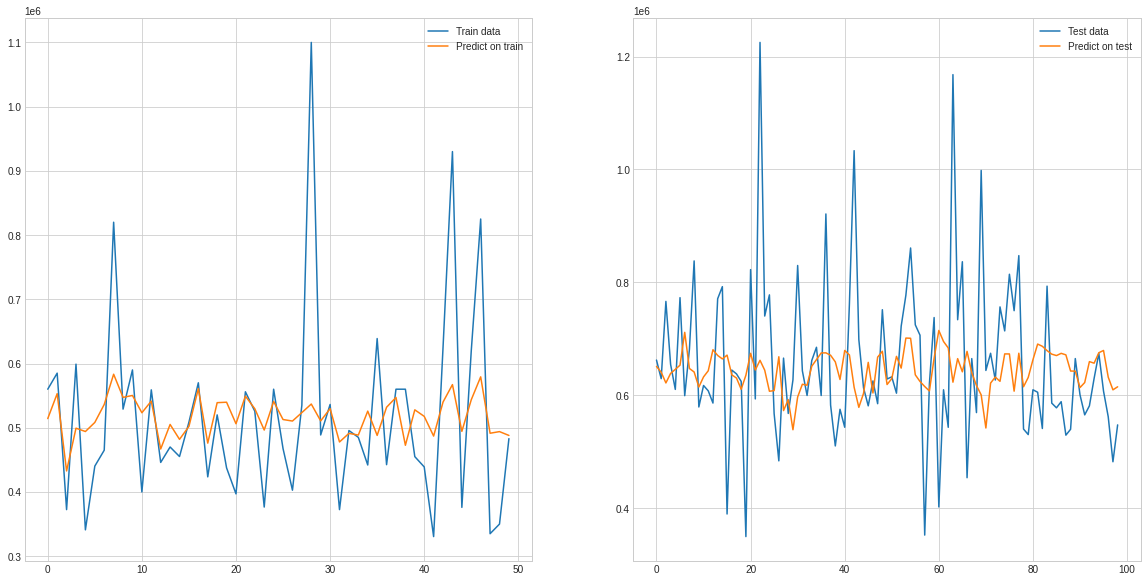

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

## Згортка + GRU/LSTM

In [ ]:
model_conv_2 = tf.keras.Sequential([
                                  layers.InputLayer((30, 1)),
                                  layers.Conv1D(30, 3, padding="same"),
                                  layers.MaxPool1D(2),
                                  layers.Dropout(0.1),
                                  layers.Conv1D(60, 3, padding="same"),
                                  layers.MaxPool1D(2),
                                  layers.Dropout(0.1),
                                  layers.GRU(240, return_sequences=True, input_shape = (None, 420)),
                                  layers.Dropout(0.1),
                                  layers.LSTM(120),
                                  layers.Dropout(0.1),
                                  layers.Dense(1)
                               
])
model_conv_2.compile(loss = "mse", optimizer=tf.keras.optimizers.Adam())

In [ ]:
with tf.device("/device:GPU:0"):
  history_conv_2 = model_conv_2.fit(
      ts_train_X.reshape(len(ts_train_X), 30, 1),
      ts_train_y,
      epochs = 12,
  )

Epoch 1/12
27/27 [==============================] - 2s 5ms/step - loss: 0.0189
Epoch 2/12
27/27 [==============================] - 0s 5ms/step - loss: 0.0170
Epoch 3/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0159
Epoch 4/12
27/27 [==============================] - 0s 5ms/step - loss: 0.0157
Epoch 5/12
27/27 [==============================] - 0s 5ms/step - loss: 0.0159
Epoch 6/12
27/27 [==============================] - 0s 5ms/step - loss: 0.0161
Epoch 7/12
27/27 [==============================] - 0s 5ms/step - loss: 0.0156
Epoch 8/12
27/27 [==============================] - 0s 5ms/step - loss: 0.0163
Epoch 9/12
27/27 [==============================] - 0s 5ms/step - loss: 0.0157
Epoch 10/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0155
Epoch 11/12
27/27 [==============================] - 0s 5ms/step - loss: 0.0160
Epoch 12/12
27/27 [==============================] - 0s 6ms/step - loss: 0.0155


In [ ]:
pred_train = model_conv_2.predict(ts_train_X.reshape(len(ts_train_X), 30, 1))
pred_test = model_conv_2.predict(ts_test_X.reshape(len(ts_test_X), 30, 1))
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [ ]:
calc_stats(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

RMSE on train: 112433.68644057249
RMSE on test: 129686.27133301465
MAE on train: 77847.4790792905
MAE on test: 89275.39734700577
MAPE on train: 14.374448156255234
MAPE on test: 13.521395276829825


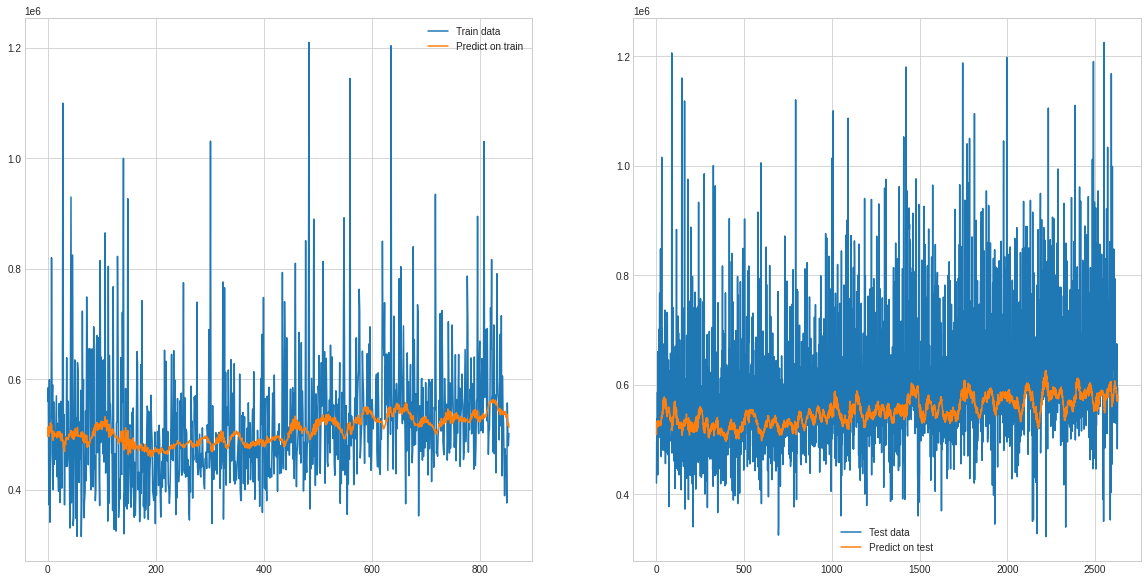

In [ ]:
plot_results(pred_train, ts_train_y_unsc, pred_test, ts_test_y_unsc)

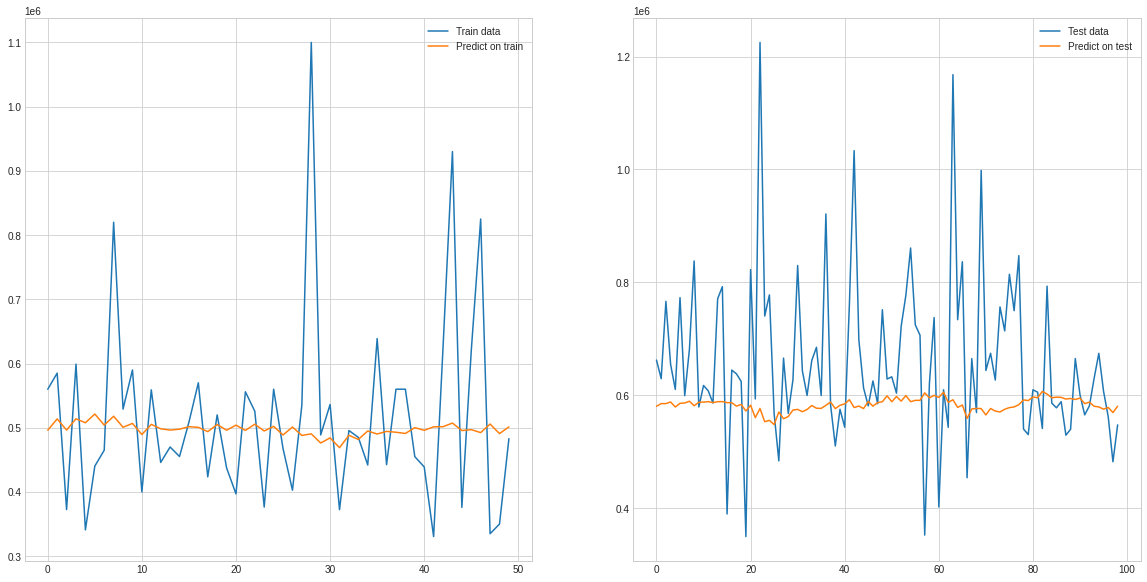

In [ ]:
plot_results(pred_train[:50], ts_train_y_unsc[:50], pred_test[-100:-1], ts_test_y_unsc[-100:-1])

# Часткова автокореляційна функція

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

In [ ]:
def plot_acf(y:list, nlags:int = 24, label = None):
    '''
    Plot the ACF/PACF
    Params:
        y: list (time series)
        nlags: number of lags to use in computations
        label: label to show in the title of plot
    '''
    fig, ax = plt.subplots(1, 2,figsize=(10, 5))
    ax[0].bar(range(nlags+1),acf(y, nlags = nlags));
    ax[1].bar(range(nlags+1),pacf(y, nlags = nlags));
    ax[0].set_title(r"ACF of "+label)
    ax[1].set_title(r"PACF of "+label)
    fig.show();

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


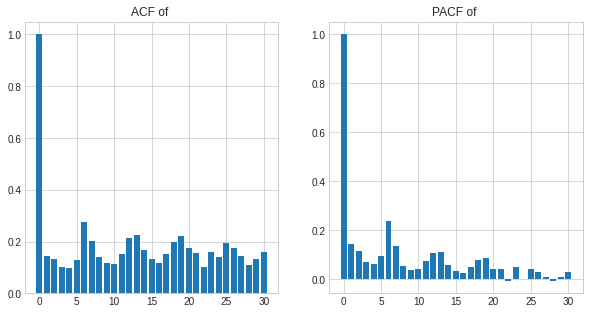

In [ ]:
plot_acf(ts, nlags = 30,label = "");